In [1]:

import numpy as np
import sys
import os
import pandas as pd
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def grouped_lineplot(df, x, y, hue, plot_marker=False, ymin=0, ymax=1, title=None, outfile=None, ci_estimator='mean'):
    fig, ax = plt.subplots(figsize=(12.5,7.5))

    g = sns.lineplot(x=x, y=y, hue=hue, data=df,
                       palette="cubehelix", estimator=ci_estimator, ax=ax)   

    sns.despine(ax=ax, left=True)
    ax.set_title(title,fontsize=24)
    ax.set_ylabel(y,fontsize=24)
    ax.set_xlabel('Order',fontsize=24)
    ax.set_ylim(ymin, ymax)
    
    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[2], handles[3], handles[4]]
    labels = [labels[1], labels[2], labels[3], labels[4]]
    
    pieman_cs = ['intact', 'paragraph', 'word', 'rest']
    
    if plot_marker:
        for e, pc in enumerate(pieman_cs):
            pd_df = df[df['Condition']==pc]
            max_level = pd_df.groupby('Level').mean()[y]
            if type(plot_marker) is list:
                plt.plot(plot_marker[e], max_level[plot_marker[e]], marker='o', color='r', markersize=14)
            else:
                plt.plot(max_level.argmax(), max_level[max_level.argmax()], marker='o', color='r', markersize=14)

    
    l = ax.legend(handles,labels, loc='center left', bbox_to_anchor=(1.00, .65), ncol=1,fontsize=24)
    l._legend_box.align = "center"
    for line in l.get_lines():
        line.set_linewidth(4.0)
    ax.tick_params(labelsize=24)
    if not outfile:
        fig.show()
    else:
        fig.savefig(outfile, bbox_inches='tight')

In [3]:
def grouped_barplot(df, x, y, hue, ymin=0, ymax=1, title=None, outfile=None):
    fig, ax = plt.subplots(figsize=(12.5,7.5))
    g = sns.factorplot(x=x, y=y, hue=hue, data=df, kind="bar", estimator=np.mean, ci=95, n_boot=1000,
                       palette="cubehelix", ax=ax, order=['intact', 'paragraph', 'word', 'rest'])

    sns.despine(ax=ax, left=True)
    ax.set_title(title, fontsize=24)
    ax.set_ylabel(y, fontsize=24)
    ax.set_xlabel(x, fontsize=24)
    ax.set_ylim(ymin, ymax)

    l = ax.legend(loc='center', bbox_to_anchor=(1, .65), ncol=1, fontsize=24)
    l._legend_box.align = "center"
    l.set_title('Order',prop={'size':24})
    
    ax.tick_params(labelsize=24)
    if not outfile:
        fig.show()
    else:
        fig.savefig(outfile, bbox_inches='tight')

In [4]:
def average_param(params, conds):
    
    ave_data = pd.DataFrame()
    for e, con in enumerate(conds):

        for p in params:

            param_name = os.path.basename(os.path.splitext(p)[0])
            full_data = combine_param_df(p)

            p_df = full_data[full_data['Condition']==con]
            ave_rel_level = p_df.groupby(['Level', 'Condition']).mean()['Relative accuracy']
            ave_z_level = p_df.groupby(['Level', 'Condition']).mean()['Z accuracy']
            ave_norm_level = p_df.groupby(['Level', 'Condition']).mean()['Normalized accuracy']
            
            p_split = param_name.split('_')

            ave_rel_df = ave_rel_level.to_frame().reset_index()
            ave_z_df = ave_z_level.to_frame().reset_index()
            ave_norm_df = ave_norm_level.to_frame().reset_index()
            
            sum_data = pd.DataFrame({'Relative accuracy': ave_rel_df['Relative accuracy'],'Z accuracy': ave_z_df['Z accuracy'], 'Normalized accuracy': ave_norm_df['Normalized accuracy'],'Level': ave_rel_df['Level'], 'Condition': ave_rel_df['Condition'], 'Reduction': p_split[1], 'Kernel': p_split[-2], 'Width': int(p_split[-1])})

            if ave_data.empty:
                ave_data = sum_data
            else:
                ave_data = ave_data.append(sum_data)
                
    return ave_data
            

In [5]:
def combine_param_df(params):
    param_name = os.path.basename(os.path.splitext(params)[0])

    conds =glob.glob(os.path.join(params, '*.csv'))

    full_data = pd.DataFrame()
    for c in conds:

        cond_name = os.path.basename(os.path.splitext(c)[0])
        chance = 1/300      
        if cond_name == 'paragraph':
            chance = 1/272
        elif cond_name == 'rest':
            chance = 1/400

        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0])
        data['Relative accuracy'] = data['accuracy'] - chance
        data['Normalized accuracy']= data['accuracy'] - np.min(data.groupby('level')['accuracy'].mean())
        data['Normalized accuracy'] = data['Normalized accuracy'] / np.max(data.groupby('level')['Normalized accuracy'].mean())
        data['Z accuracy']= (data['accuracy'] - data['accuracy'].mean())/data['accuracy'].std()

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

    full_data = full_data.rename(index=str, columns={"level": "Level", "accuracy": "Accuracy", "condition": "Condition"})

    return full_data

In [6]:
def max_level_bycolumn(ave_df, y='Relative accuracy'):
    
    pieman_cs = ['intact', 'paragraph', 'word', 'rest']
    
    max_lev = []
    for e, pc in enumerate(pieman_cs):
        pd_df = ave_df[ave_df['Condition']==pc]
        max_lev.append(pd_df.groupby('Level').mean()[y].argmax())
    
    return max_lev
        
    

In [7]:
figdir = '../figs'
if not os.path.isdir(figdir):
    os.mkdir(figdir)

In [8]:
factor_data_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')

In [9]:
analysis_name = 'level_analysis_optimized_param_search'

In [10]:
data_dir = os.path.join(factor_data_dir, analysis_name)

In [11]:
pieman_params =glob.glob(os.path.join(data_dir, '*'))

In [12]:
pieman_params

['/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_10',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_20',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_5',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_50',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_laplace_10',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_laplace_20',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/is

## Plot correlation of level and accuracy by parameters

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:18: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


<Figure size 396x324 with 0 Axes>

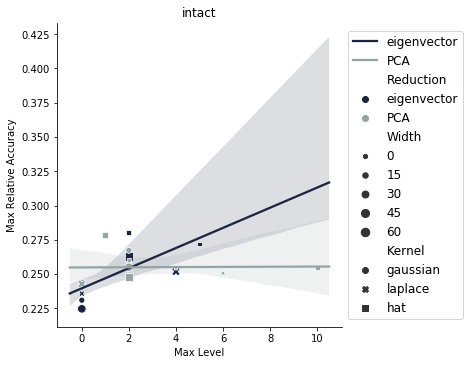

<Figure size 396x324 with 0 Axes>

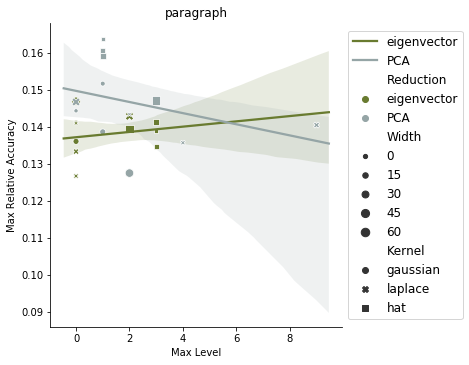

<Figure size 396x324 with 0 Axes>

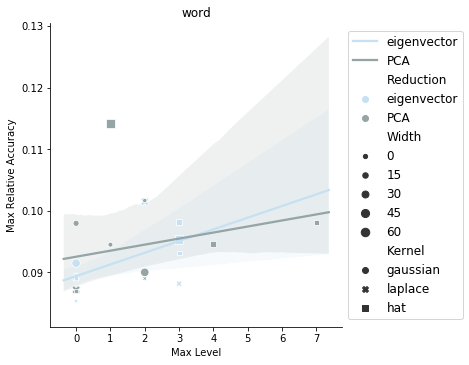

<Figure size 396x324 with 0 Axes>

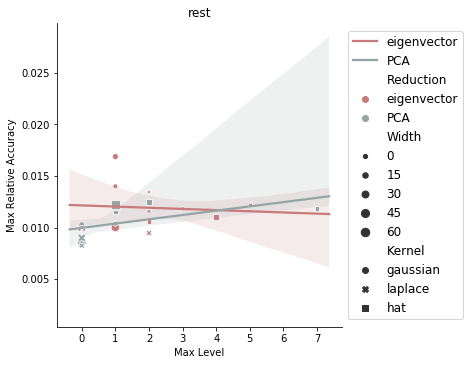

In [24]:
color_order = [0, 2, 5, 3]
pieman_conds = ['intact', 'paragraph', 'word', 'rest']

for e, con in enumerate(pieman_conds):

    all_data = pd.DataFrame()
    
    for p in pieman_params:
        
        param_name = os.path.basename(os.path.splitext(p)[0])
        full_data = combine_param_df(p)
        
        p_df = full_data[full_data['Condition']==con]
        max_level = p_df.groupby('Level').mean()['Relative accuracy']

        p_split = param_name.split('_')

        sum_data = pd.DataFrame({'Max Relative Accuracy': max_level[max_level.argmax()], 'Max Level': max_level.argmax(), 'Reduction': p_split[1], 'Kernel': p_split[-2], 'Width': int(p_split[-1])}, index=[0])

        if all_data.empty:
            all_data = sum_data
        else:
            all_data = all_data.append(sum_data)
    
               
    fig= plt.figure(figsize=(5.5,4.5))
    ax = sns.lmplot(x = 'Max Level', y = 'Max Relative Accuracy' , hue = 'Reduction',palette = dict(eigenvector=sns.color_palette("cubehelix")[color_order[e]], PCA="#95a5a6"), scatter=False, legend=False, data = all_data)
    sns.scatterplot(x = 'Max Level', y = 'Max Relative Accuracy' , hue = 'Reduction', style = 'Kernel', size = 'Width', palette = dict(eigenvector=sns.color_palette("cubehelix")[color_order[e]], PCA="#95a5a6"),data = all_data)
    plt.legend(loc='center left', bbox_to_anchor=(1.00, .5), ncol=1,fontsize=12)
    plt.title(con)

## Plot average across all parameters

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


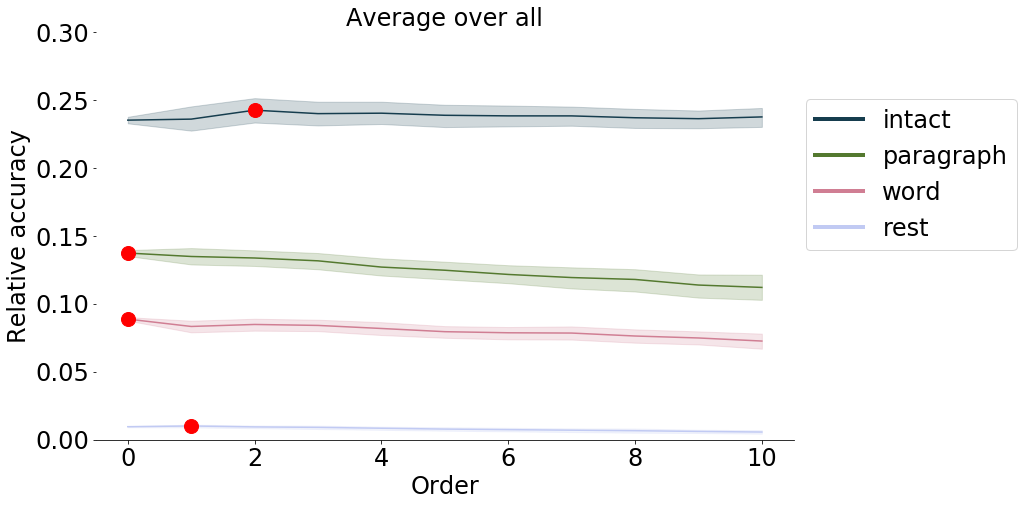

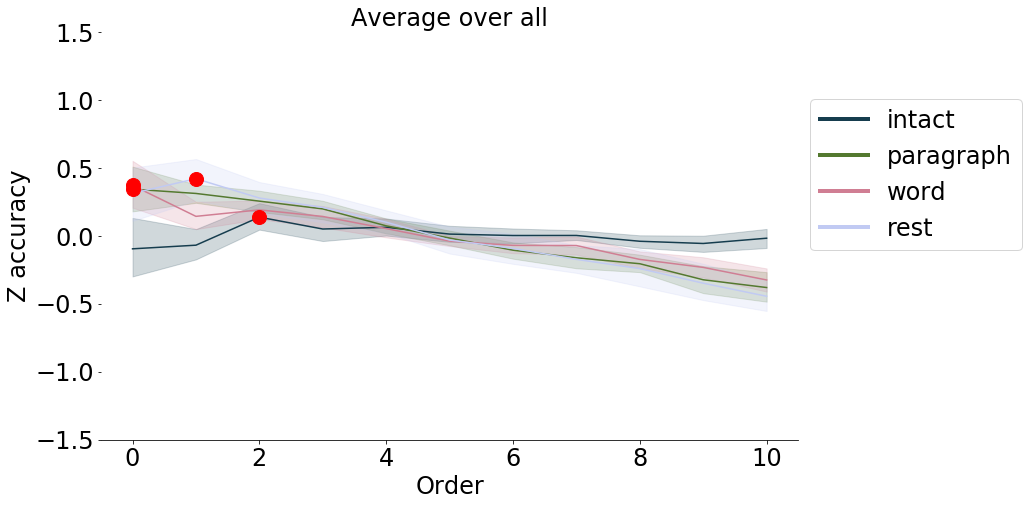

In [31]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']

all_data = average_param(pieman_params, pieman_conds)
            
#outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
outfile=None
grouped_lineplot(all_data, 'Level', 'Relative accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = 'Average over all', outfile=outfile)
plt.show()
plt.close()
               
grouped_lineplot(all_data, 'Level', 'Z accuracy','Condition', plot_marker=True, ymin=-1.5, ymax=1.5, title = 'Average over all', outfile=outfile)
plt.show()
plt.close()

## Plot average across kernel type

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


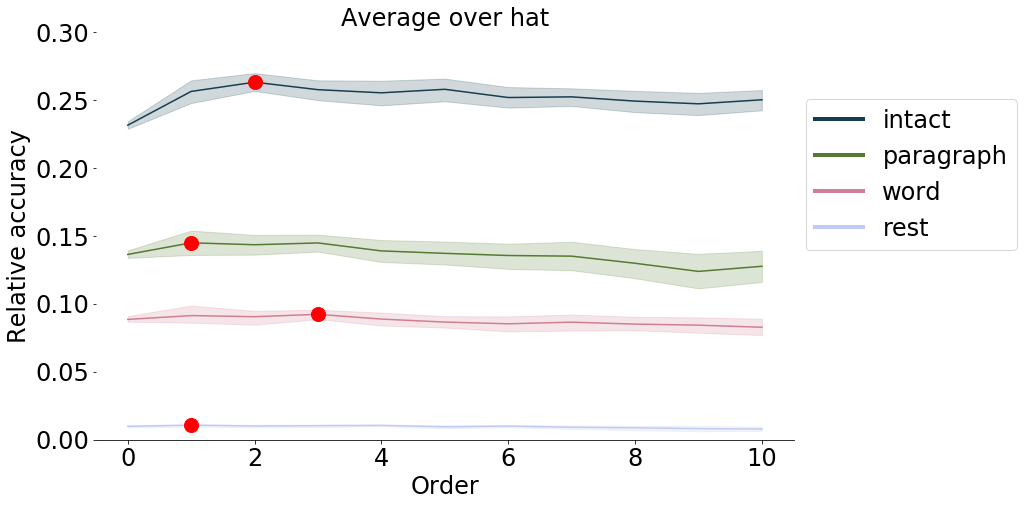

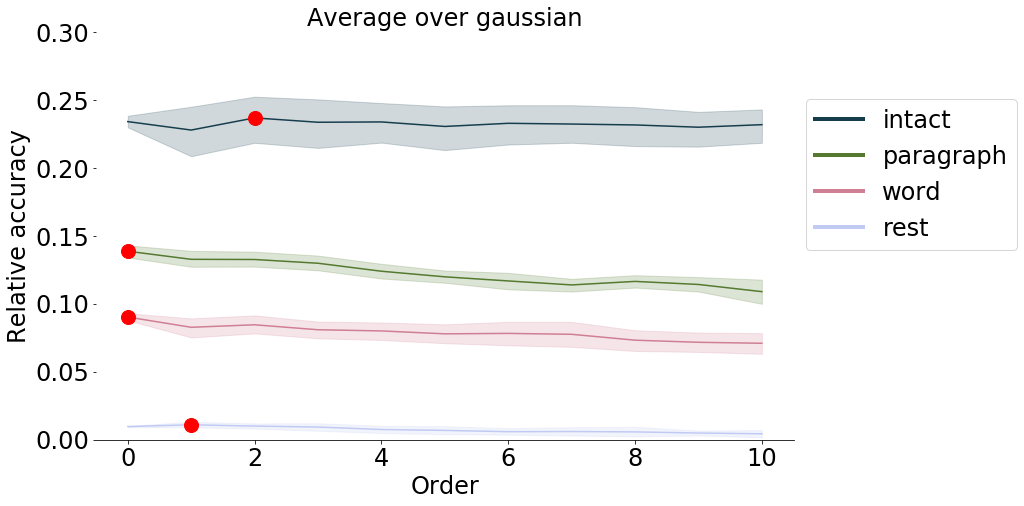

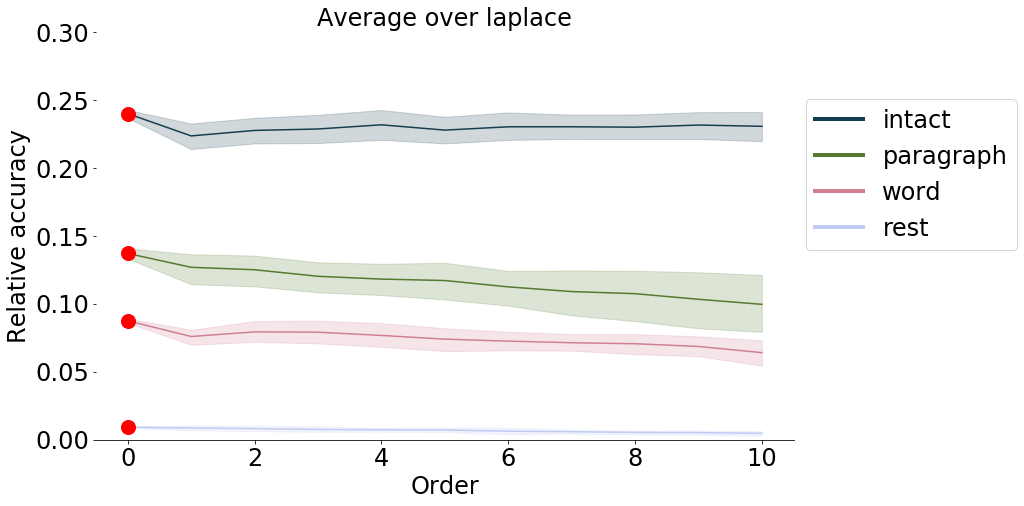

In [15]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']
Reduction_type = ['PCA', 'eigenvector']
Kernel_type = ['hat', 'gaussian', 'laplace']

split_by = 'Kernel'

all_data = average_param(pieman_params, pieman_conds)

for i in eval(split_by + '_type'):

    #outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
    outfile=None
    grouped_lineplot(all_data[all_data[split_by]==i], 'Level', 'Relative accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = 'Average over ' + i, outfile=outfile)
    plt.show()
    plt.close()
               


## Plot average across reduction type

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


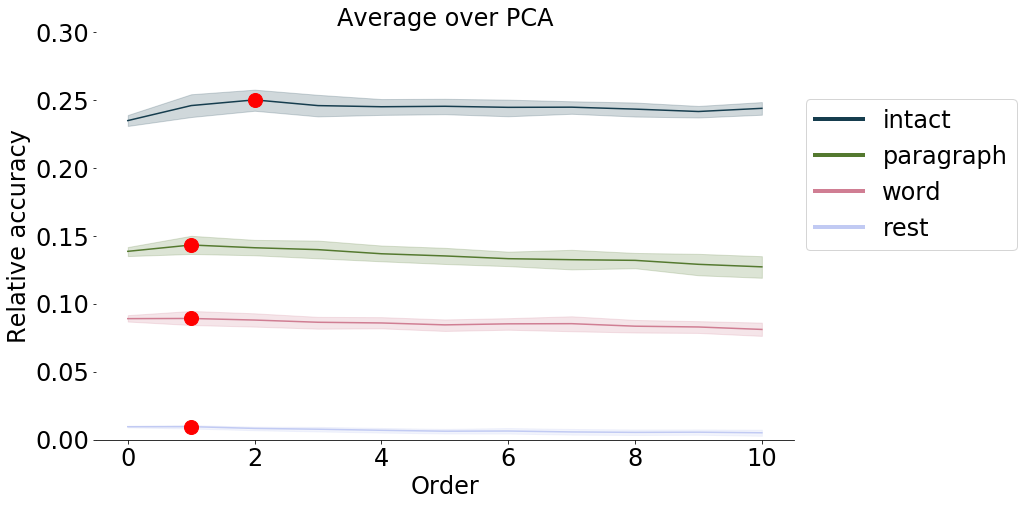

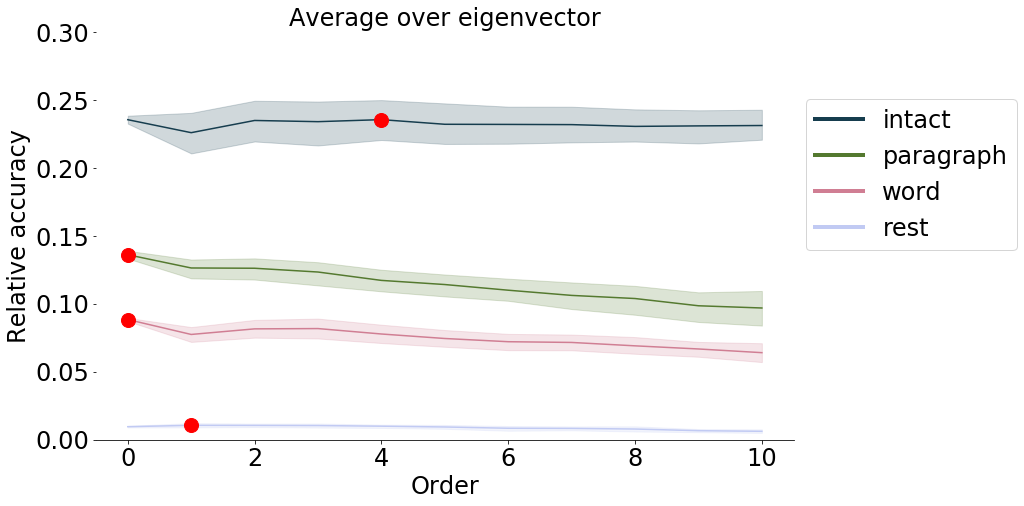

In [16]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']
Reduction_type = ['PCA', 'eigenvector']
Kernel_type = ['hat', 'gaussian', 'laplace']
Width_type = [5, 10, 20, 50]

split_by = 'Reduction'

all_data = average_param(pieman_params, pieman_conds)

for i in eval(split_by + '_type'):
    
            
    #outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
    outfile=None
    grouped_lineplot(all_data[all_data[split_by]==i], 'Level', 'Relative accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = 'Average over ' + i, outfile=outfile)
    plt.show()
    plt.close()

In [17]:
split_by = 'Reduction'

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


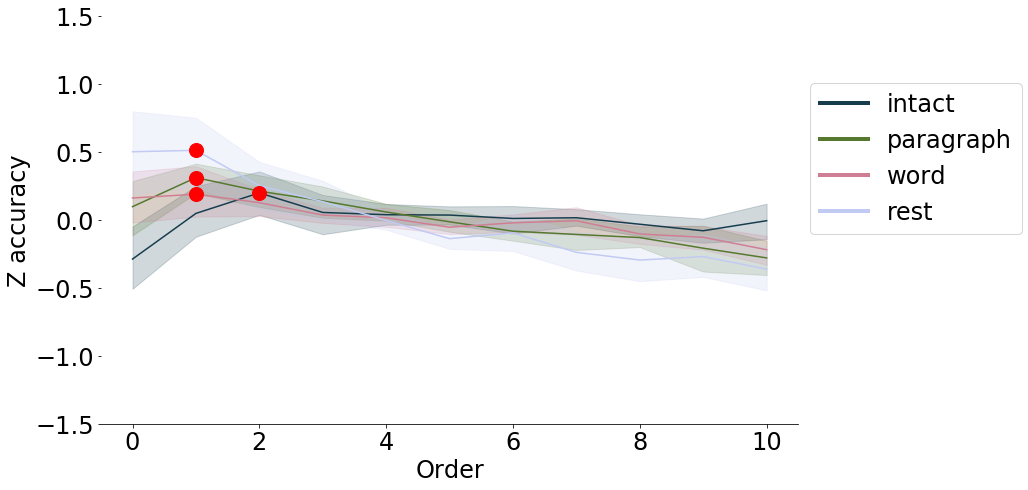

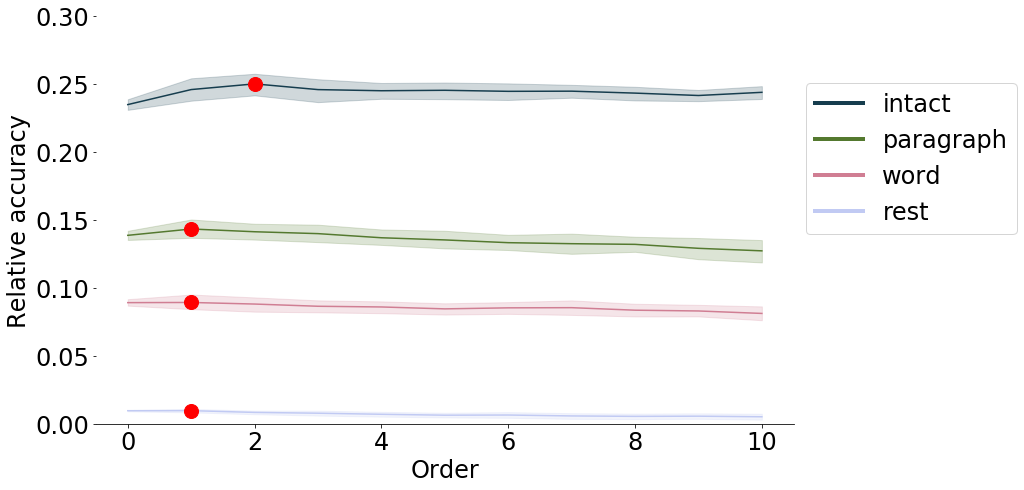

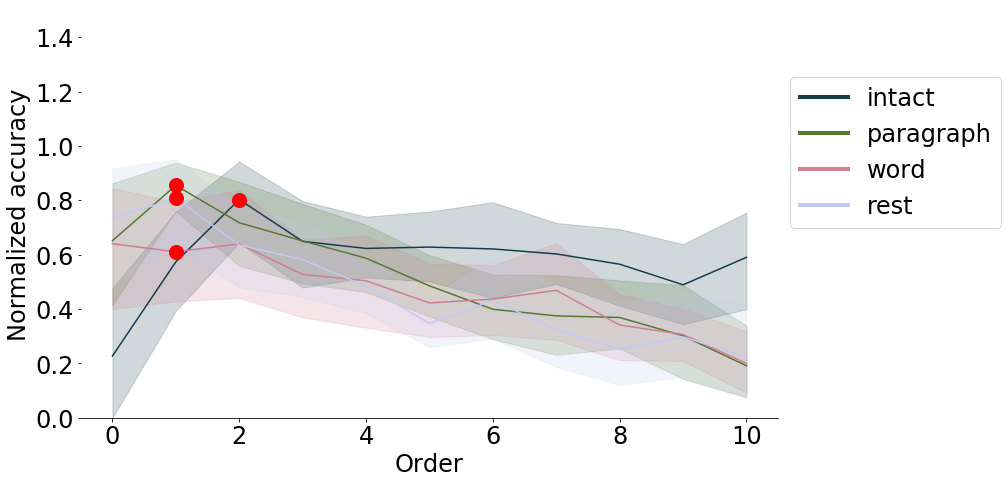

In [18]:
reduction_type = 'PCA'

all_data = average_param(pieman_params, pieman_conds)

markers_y = max_level_bycolumn(all_data[all_data[split_by]==reduction_type], y='Relative accuracy')

outfile = os.path.join(figdir, reduction_type + '_z_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Z accuracy','Condition', plot_marker=markers_y, ymin=-1.5, ymax=1.5, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_rel_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Relative accuracy','Condition', plot_marker=markers_y, ymin=0, ymax=.3, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_norm_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Normalized accuracy','Condition', plot_marker=markers_y, ymin=0, ymax=1.5, title = '', outfile=outfile)
plt.show()
plt.close()

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


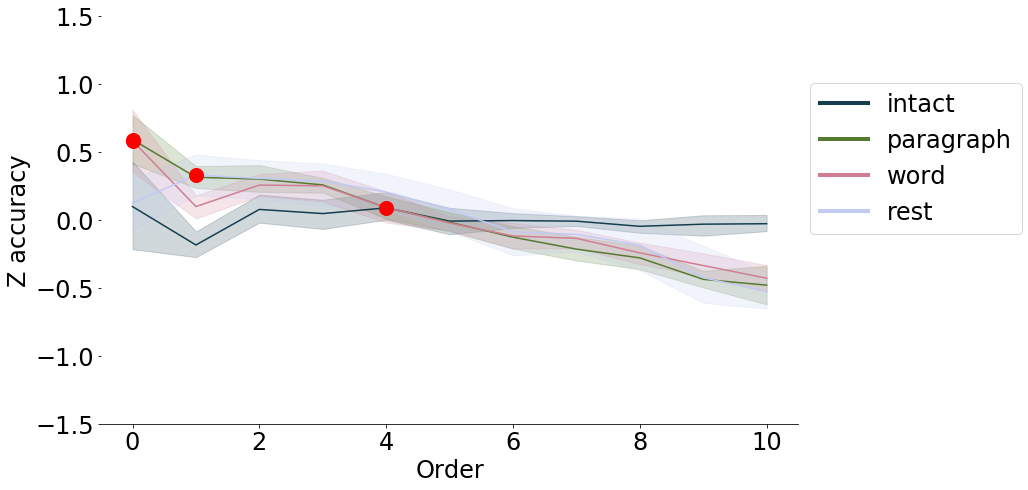

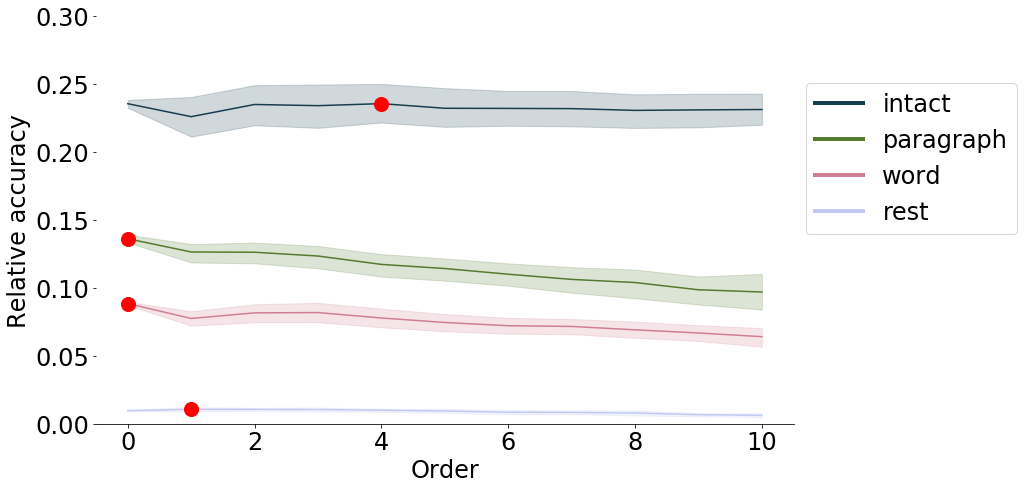

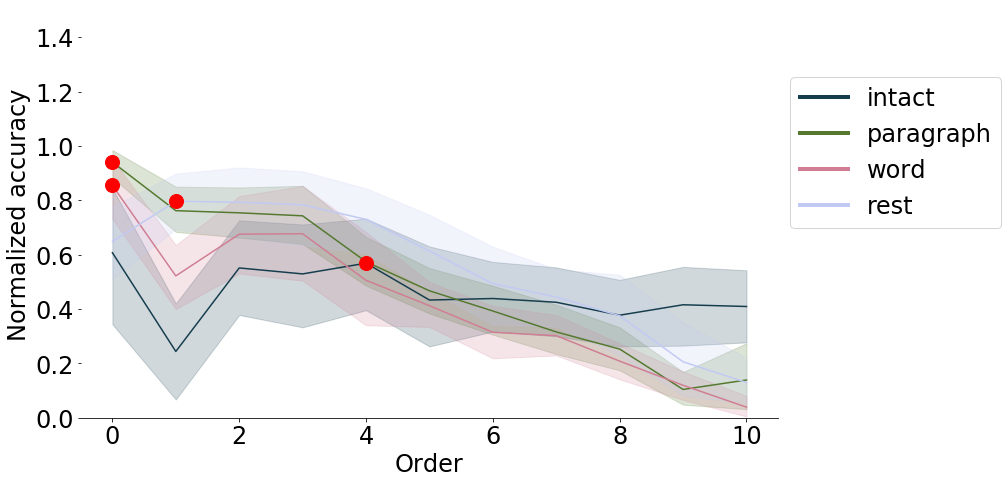

In [19]:
reduction_type = 'eigenvector'

all_data = average_param(pieman_params, pieman_conds)

markers_y = max_level_bycolumn(all_data[all_data[split_by]==reduction_type], y='Relative accuracy')

outfile = os.path.join(figdir, reduction_type + '_z_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Z accuracy','Condition', plot_marker=markers_y, ymin=-1.5, ymax=1.5, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_rel_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Relative accuracy','Condition', plot_marker=markers_y, ymin=0, ymax=.3, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_norm_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Normalized accuracy','Condition', plot_marker=markers_y, ymin=0, ymax=1.5, title = '', outfile=outfile)
plt.show()
plt.close()

## Plot average across width

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


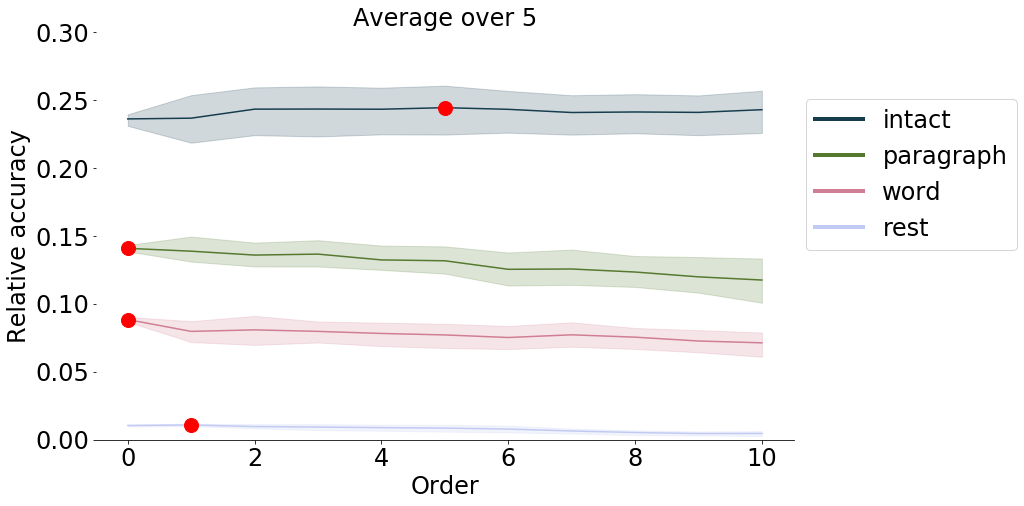

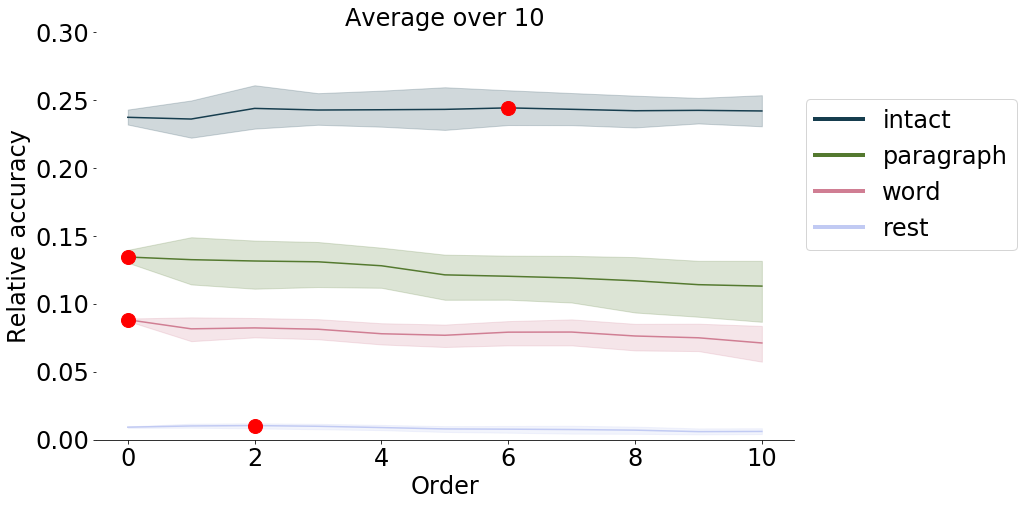

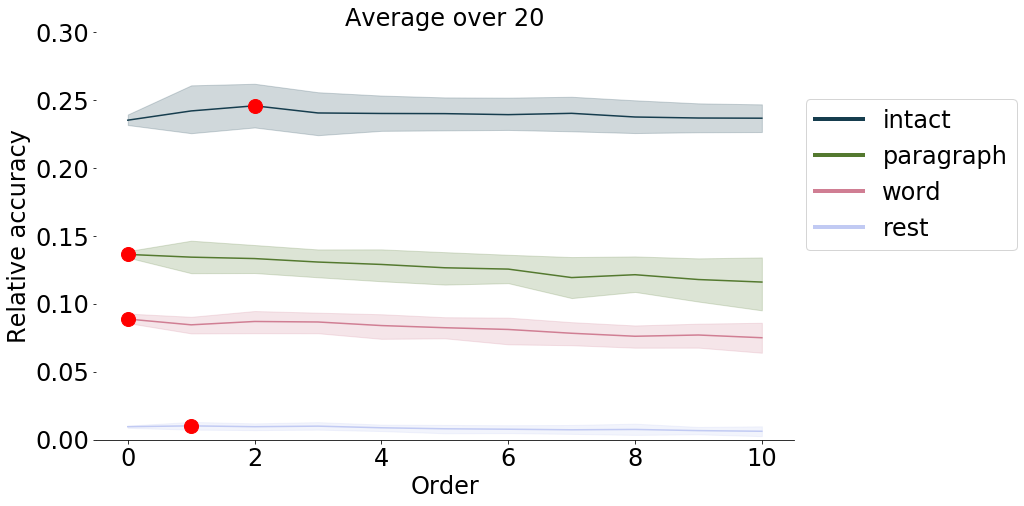

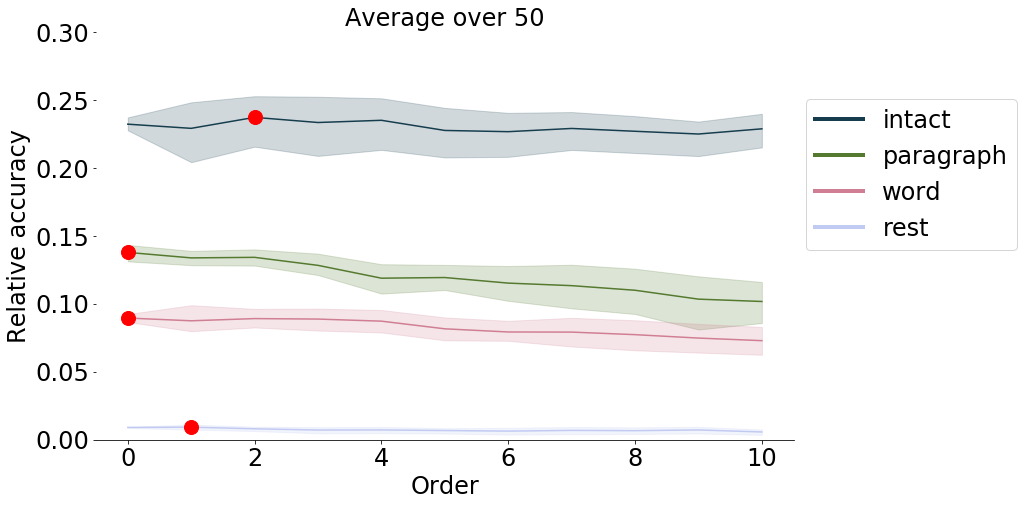

In [20]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']
Reduction_type = ['PCA', 'eigenvector']
Kernel_type = ['hat', 'gaussian', 'laplace']
Width_type = [5, 10, 20, 50]

split_by = 'Width'

all_data = average_param(pieman_params, pieman_conds)
    
for i in eval(split_by + '_type'):
            
    #outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
    outfile=None
    grouped_lineplot(all_data[all_data[split_by]==i], 'Level', 'Relative accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = 'Average over ' + str(i), outfile=outfile)
    plt.show()
    plt.close()
               


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  
/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


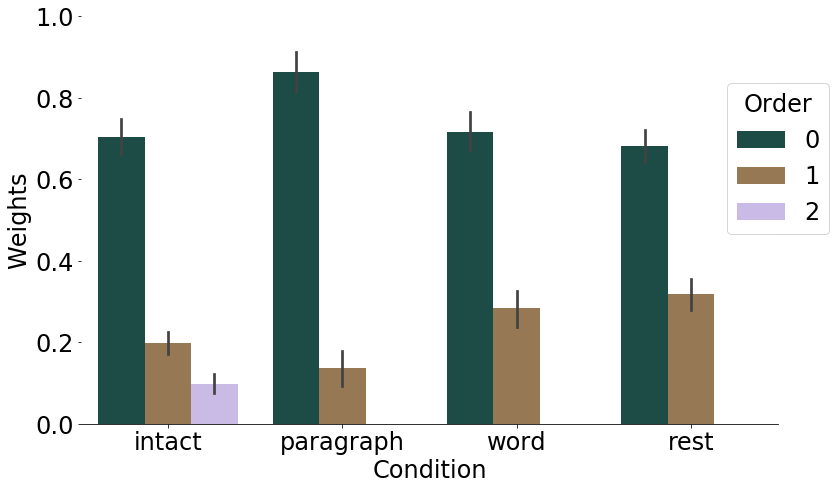

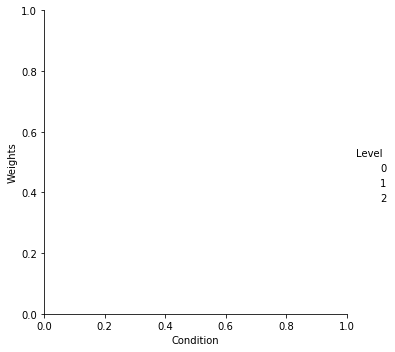

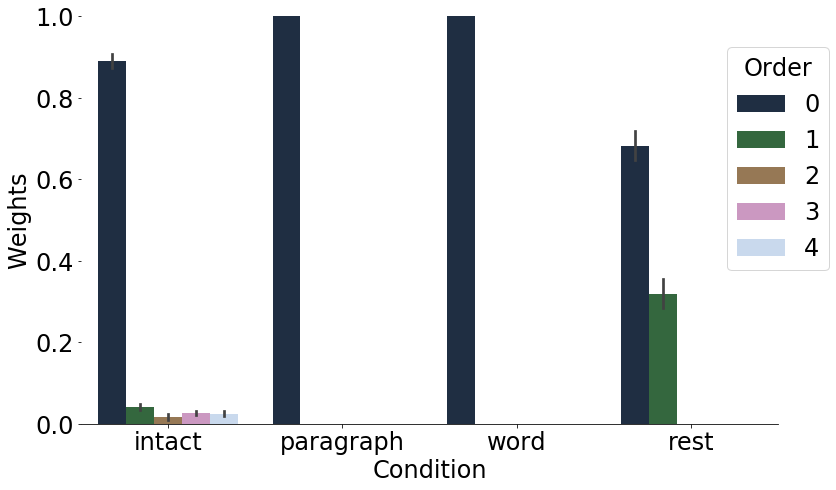

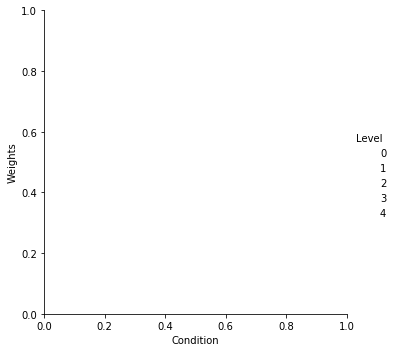

In [21]:

factors = 700
pieman_conds = ['intact', 'paragraph', 'word', 'rest']

split_by = 'Reduction'

for i in eval(split_by + '_type'):
    new_melt = pd.DataFrame()

    all_data = average_param(pieman_params, pieman_conds)
    max_levels = max_level_bycolumn(all_data[all_data[split_by]==i], y='Relative accuracy')
    for p in pieman_params:
        
        param_name = os.path.basename(os.path.splitext(p)[0])
        p_split = param_name.split('_')
        
        if p_split[1] == i:
            
            for e, cond in enumerate(pieman_conds):

                p_df = full_data[full_data['Condition']==cond]

                max_level = max_levels[e]

                p_df = p_df[p_df['Level'] == max_level]

                for c in np.arange(max_level + 1):
                    melted_temp_df = pd.DataFrame()

                    melted_temp_df['Weights'] = p_df['level_' + str(c)]


                    melted_temp_df['Level'] = c

                    melted_temp_df['Condition'] = p_df['Condition']

                    if new_melt.empty:
                        new_melt = melted_temp_df
                    else:
                        new_melt= new_melt.append(melted_temp_df)


    new_melt= new_melt.append(melted_temp_df)

    p_split = param_name.split('_')

    title = p_split[0] + ' ' + p_split[1] + ' ' + p_split[-2] + ' ' + p_split[-1] 
    #outfile=None
    outfile = os.path.join(figdir, i + '_weights_ave_'+ analysis_name + '.pdf')
    grouped_barplot(new_melt, 'Condition', 'Weights', 'Level', ymin=0, ymax=1, title = '', outfile=outfile)
    plt.show()
    plt.close()

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:32: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:33: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


0.24549999999999997
0
isfc eigenvector gaussian 10


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


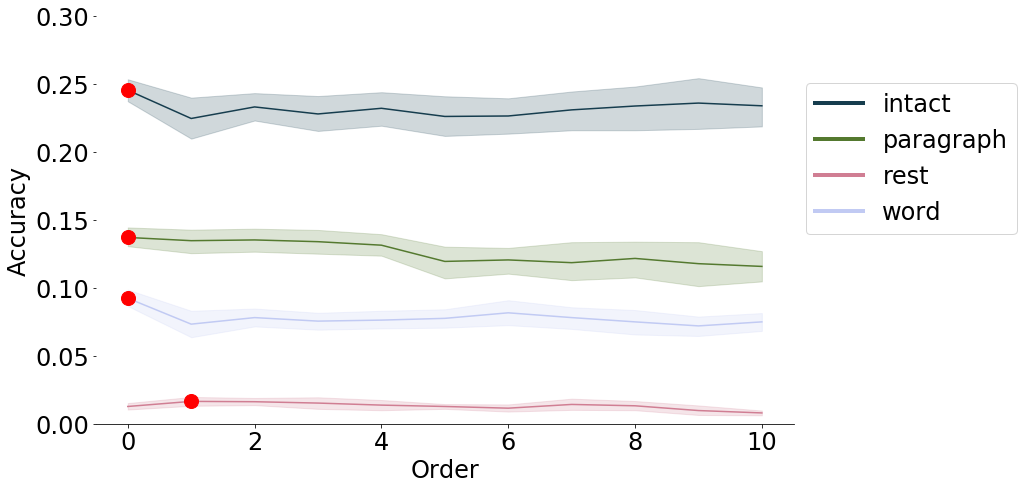

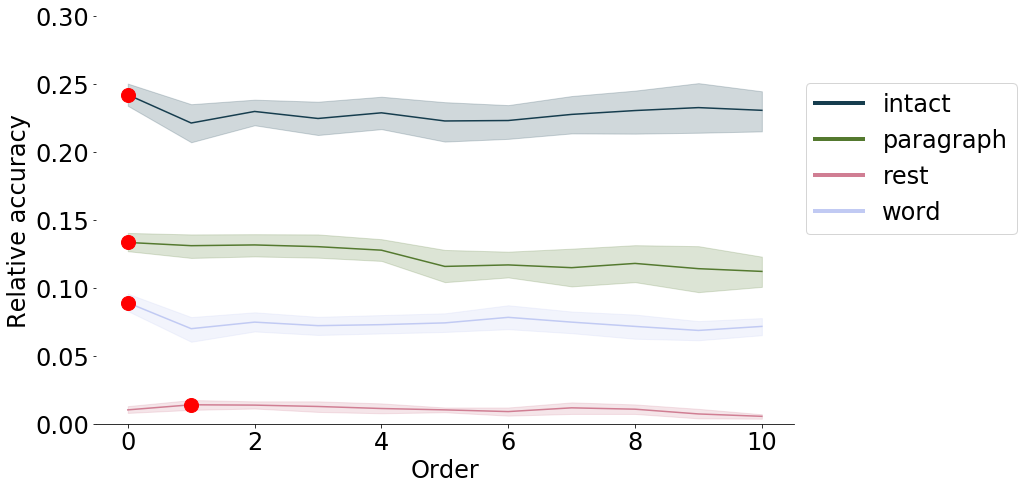

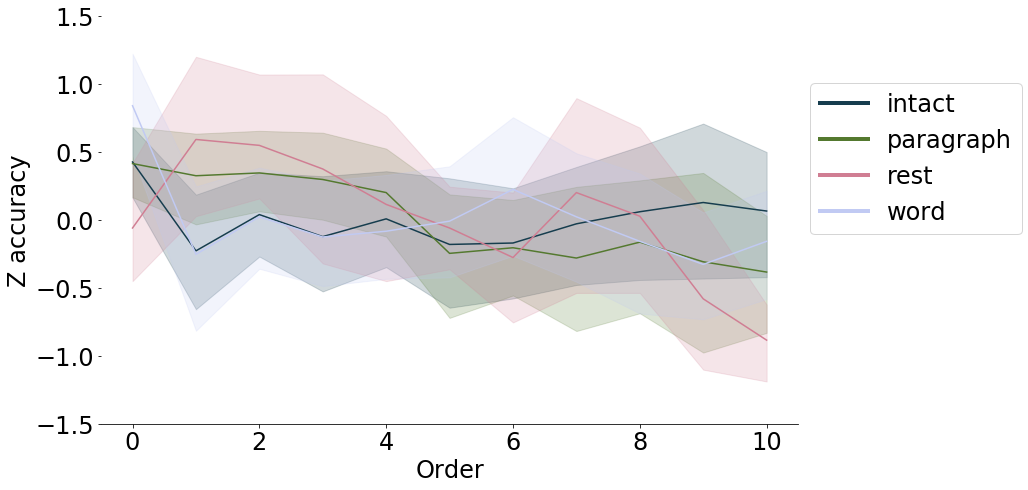

0.23428571428571424
0
isfc eigenvector gaussian 20


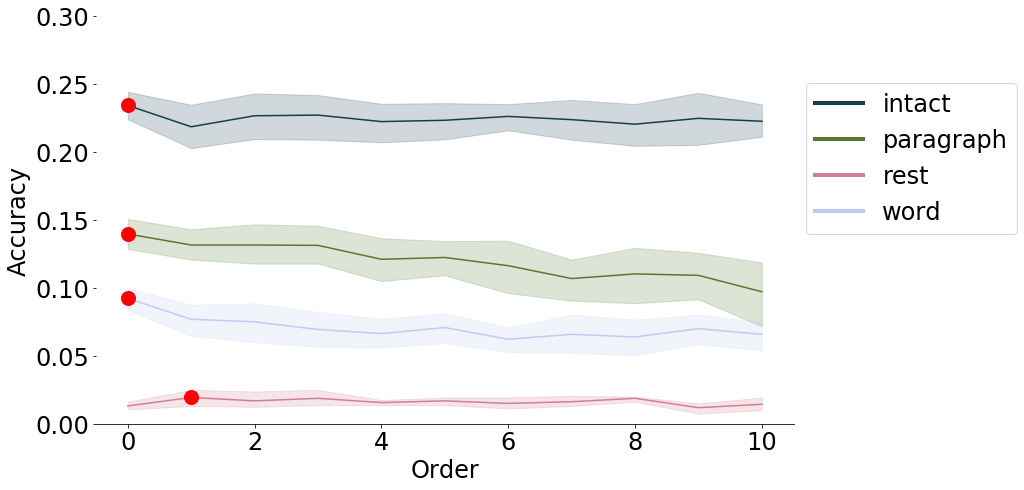

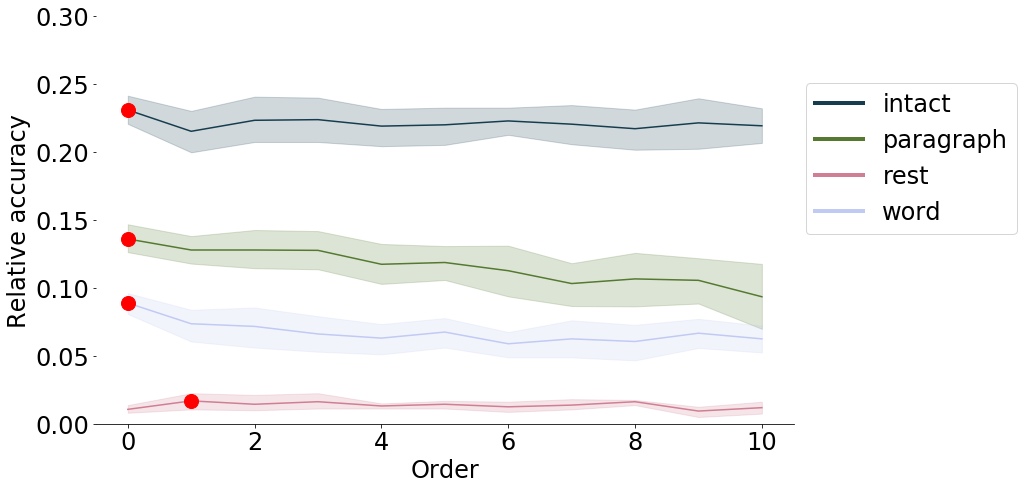

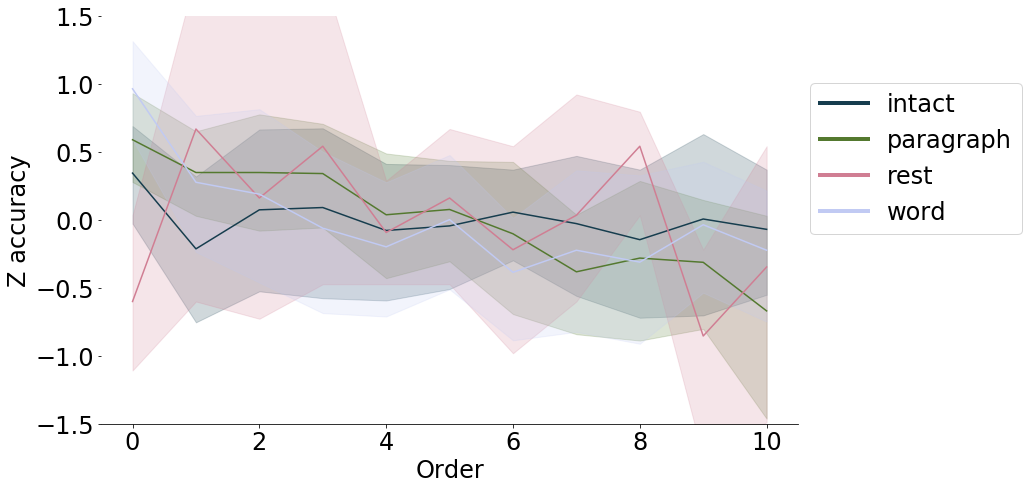

0.23979166666666663
0
isfc eigenvector gaussian 5


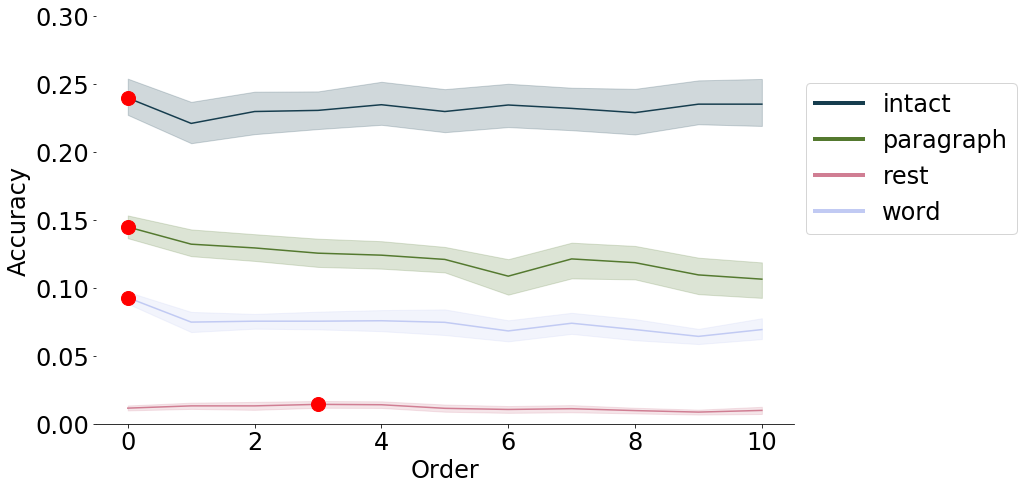

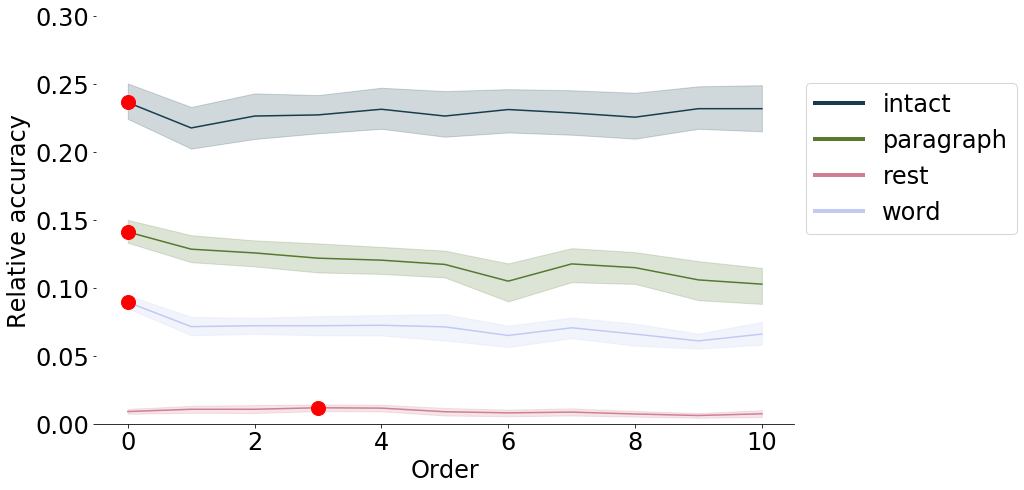

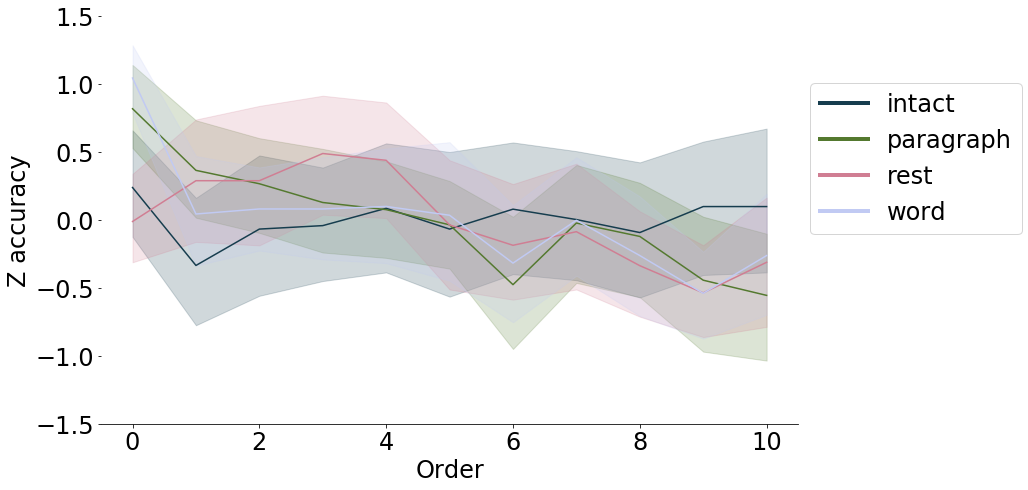

0.22799999999999998
0
isfc eigenvector gaussian 50


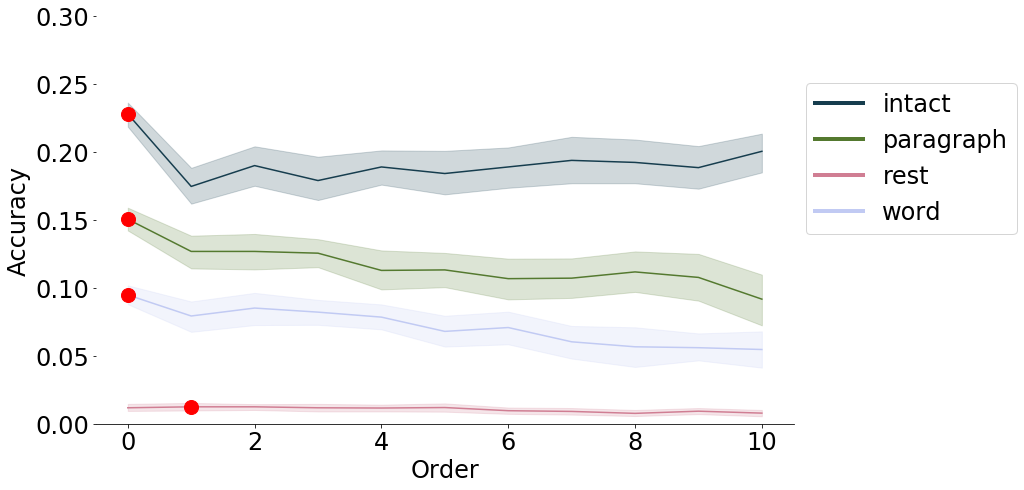

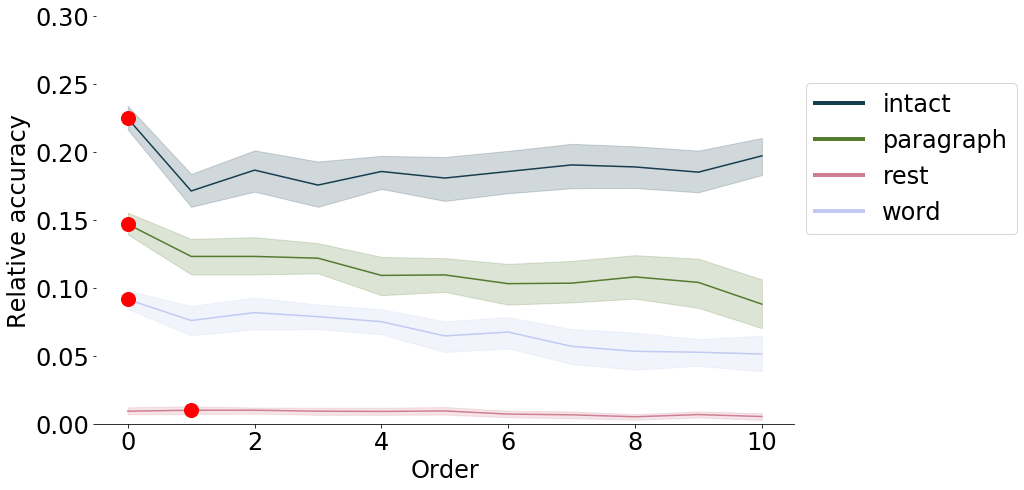

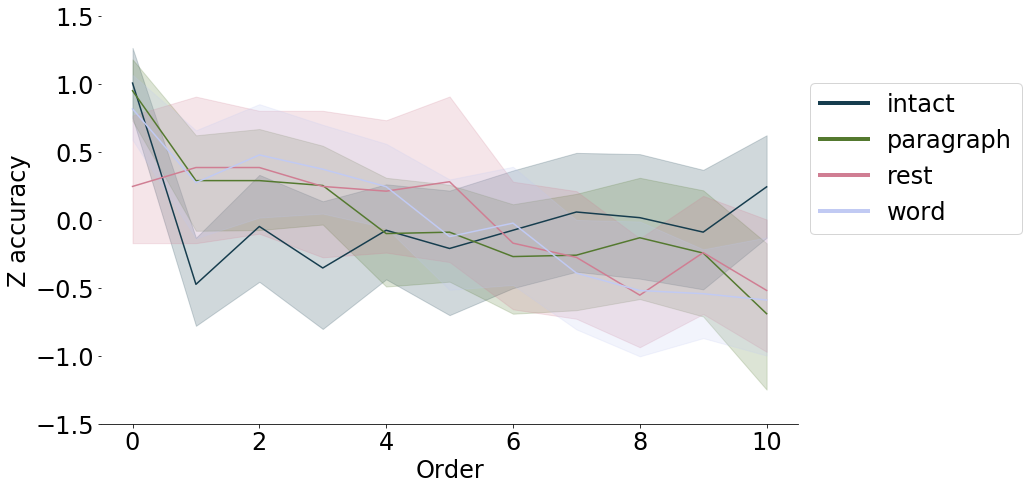

0.24783333333333335
0
isfc eigenvector laplace 10


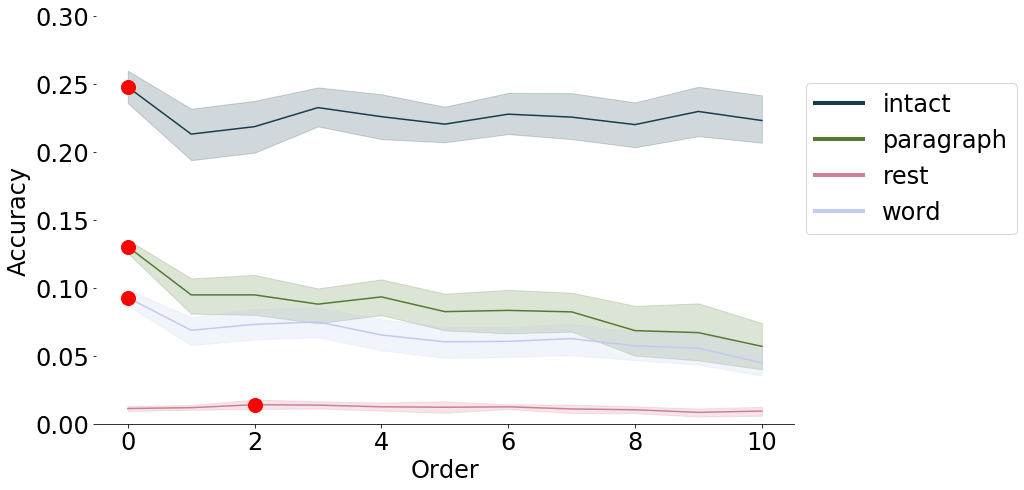

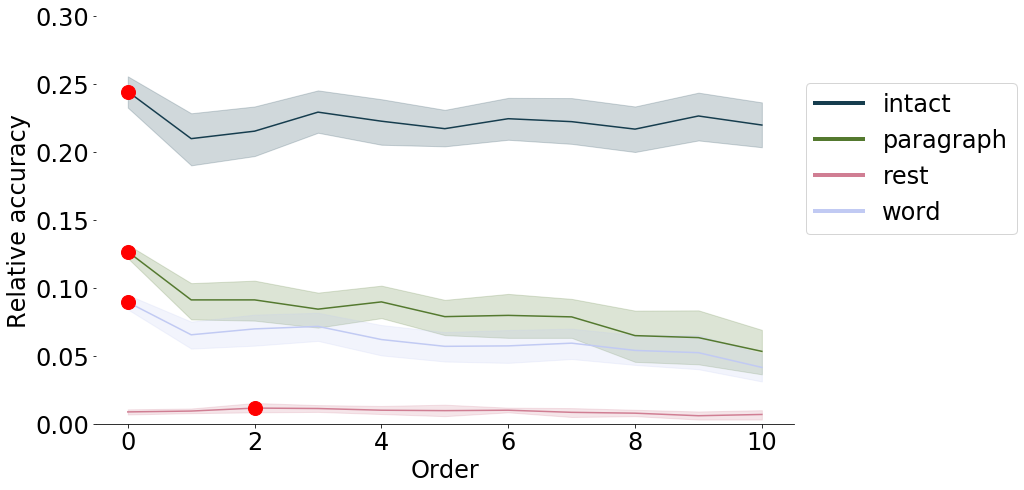

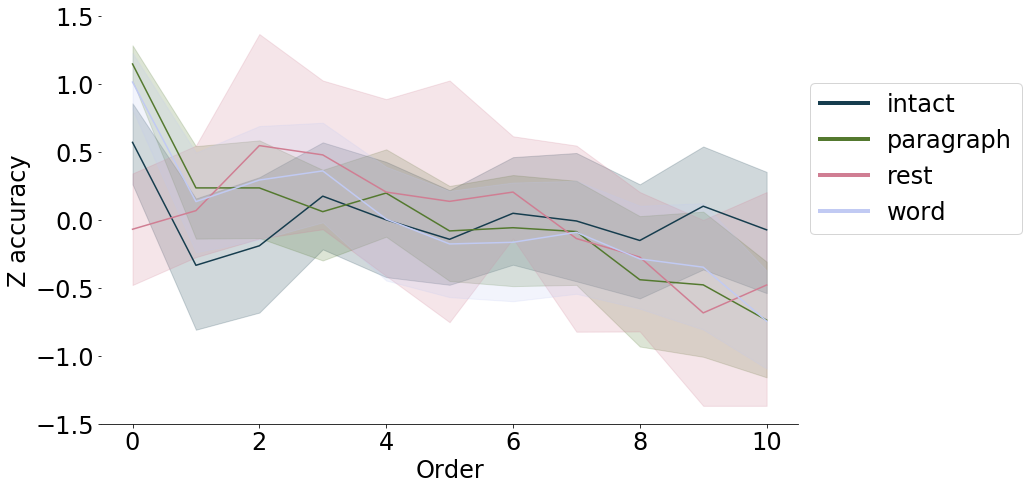

0.23907407407407405
0
isfc eigenvector laplace 20


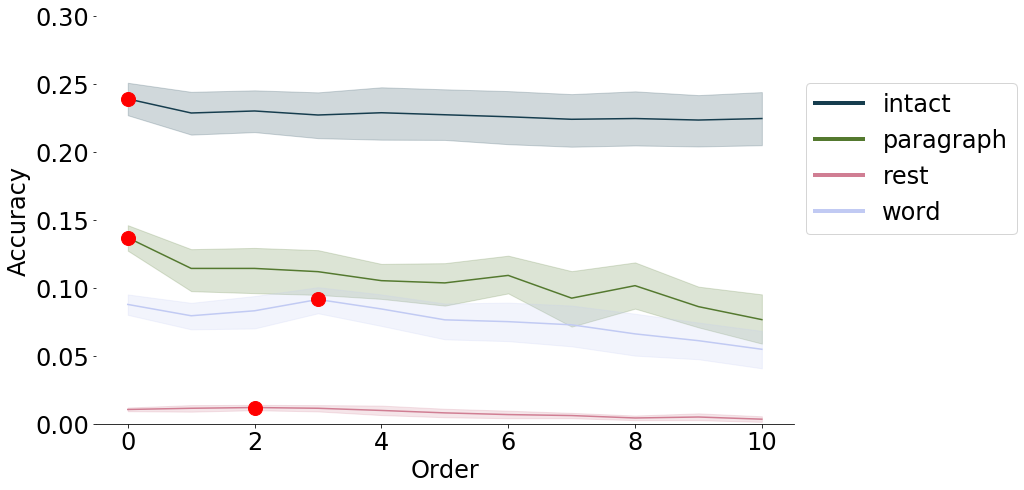

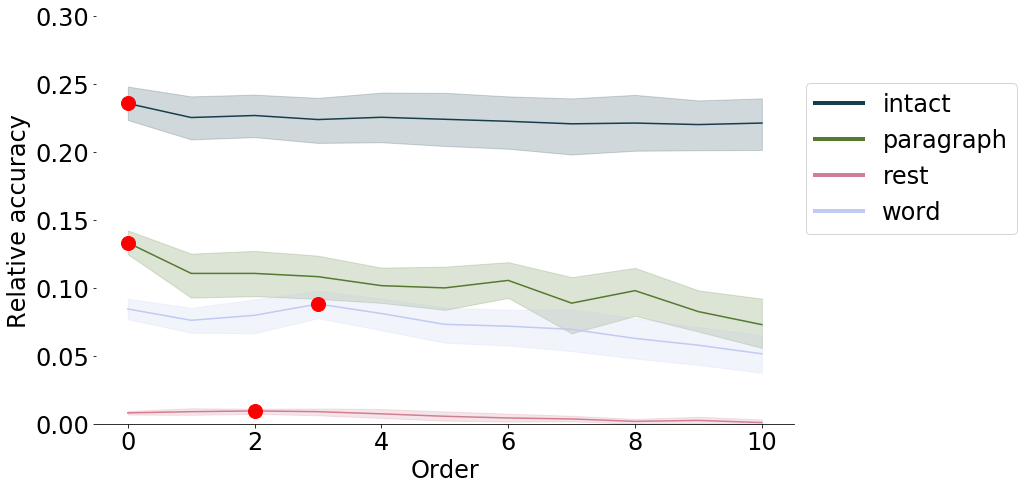

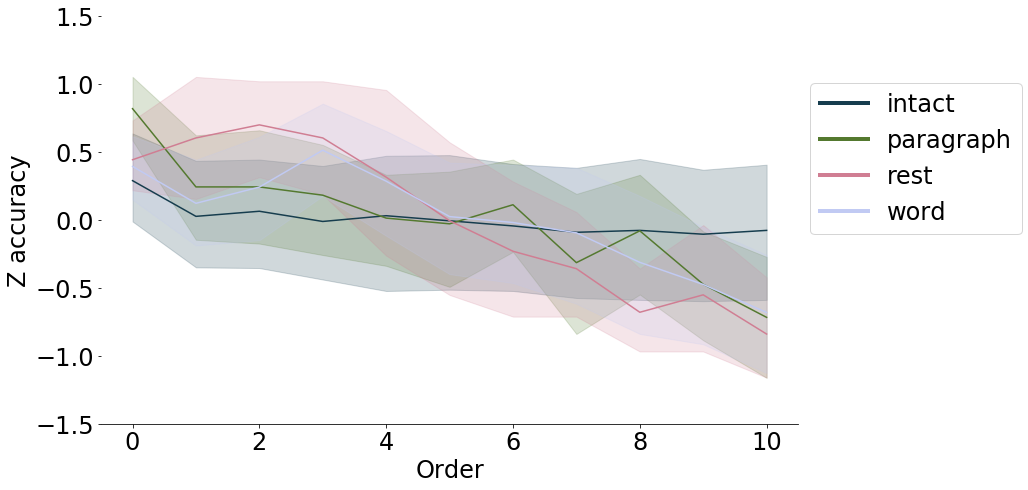

0.242962962962963
0
isfc eigenvector laplace 5


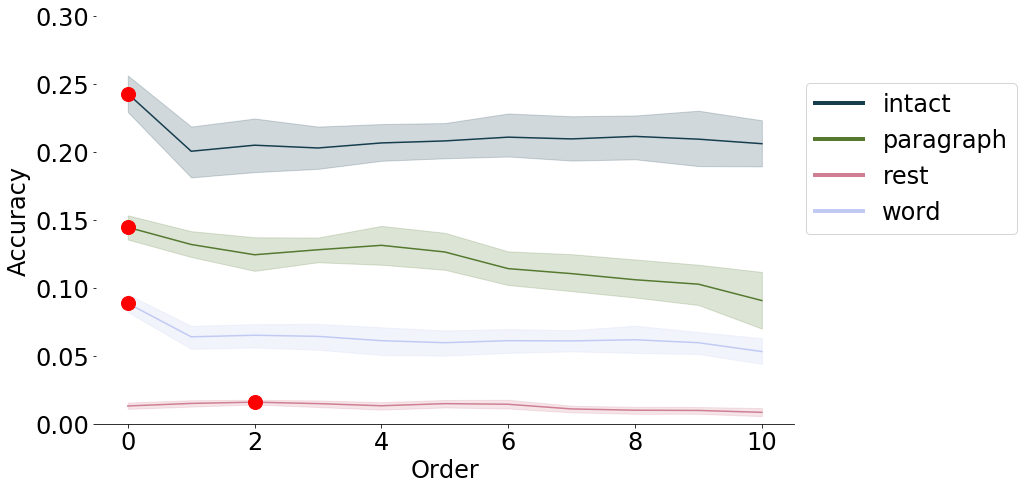

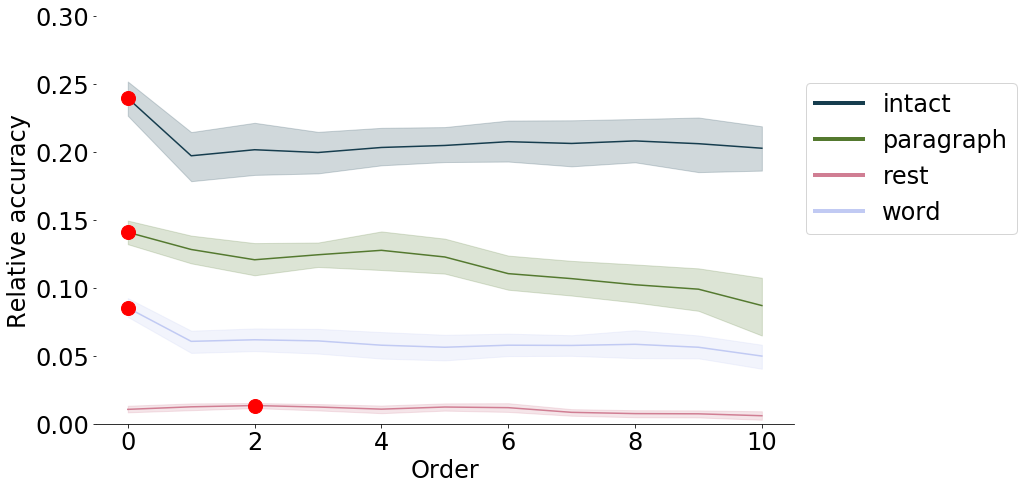

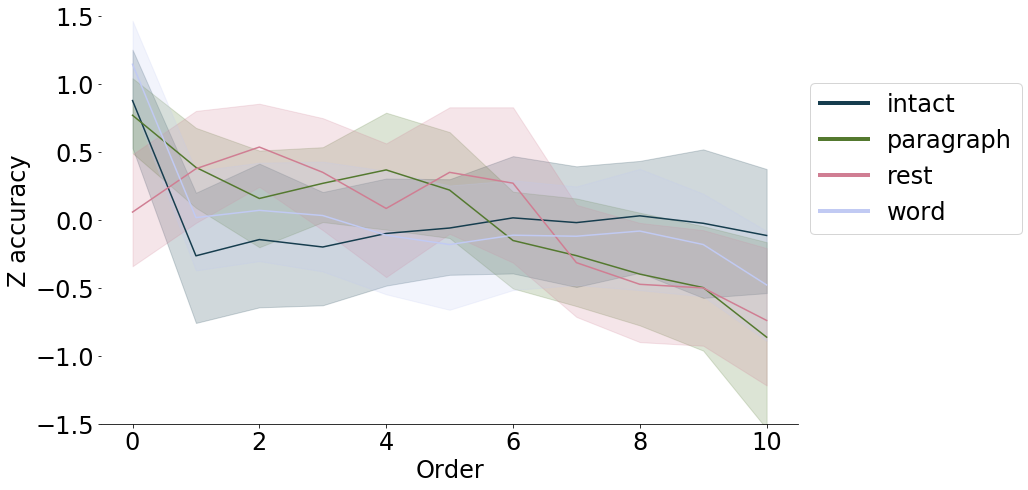

0.25516666666666665
4
isfc eigenvector laplace 50


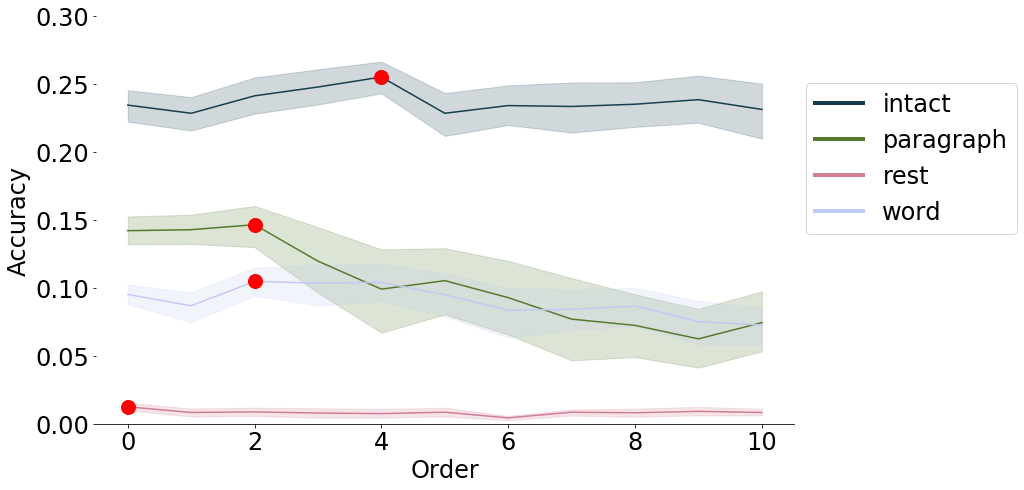

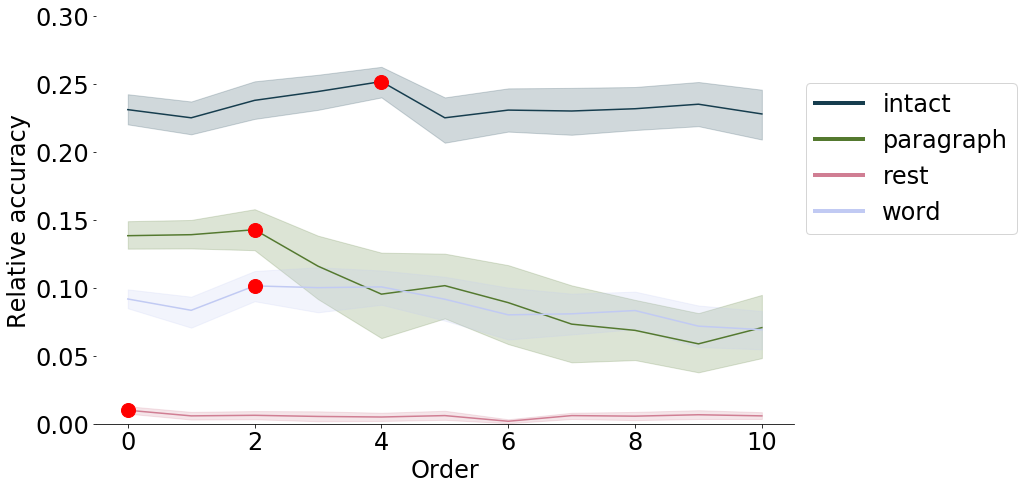

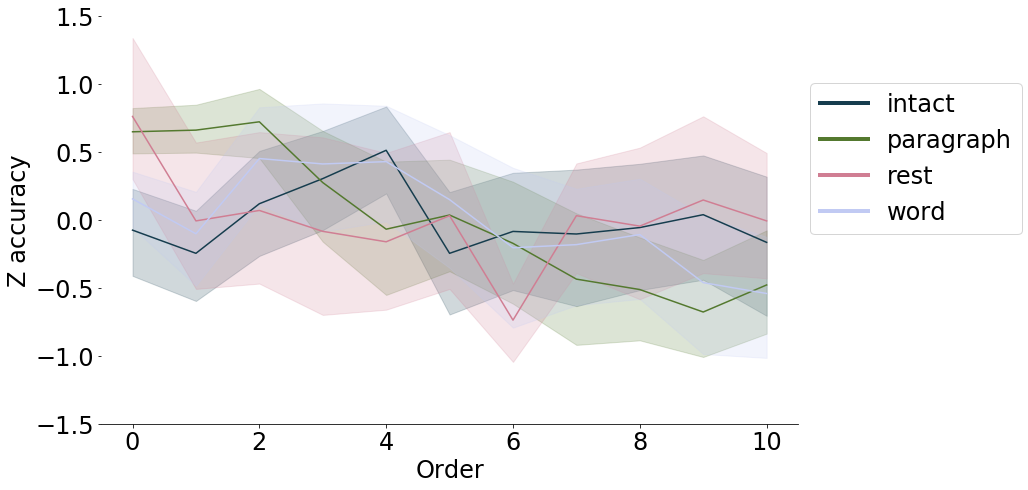

0.2838333333333334
2
isfc eigenvector hat 10


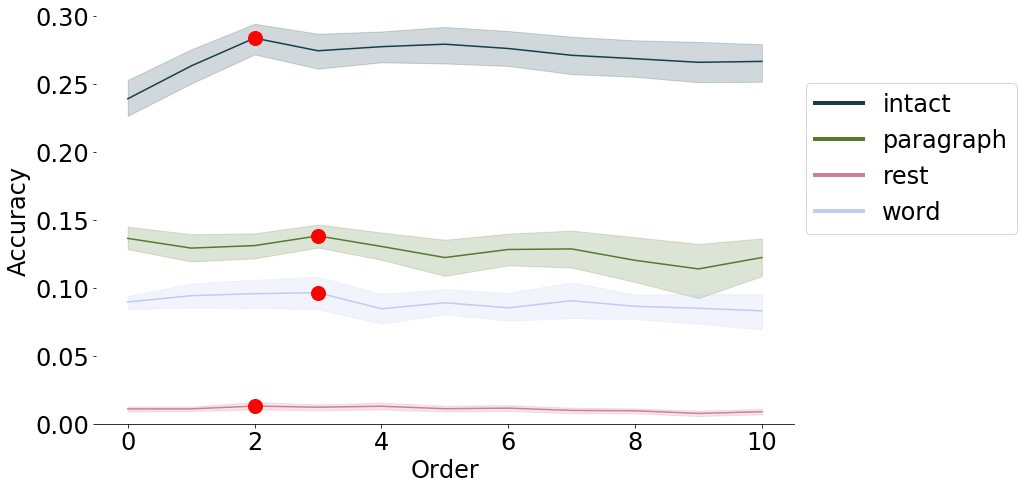

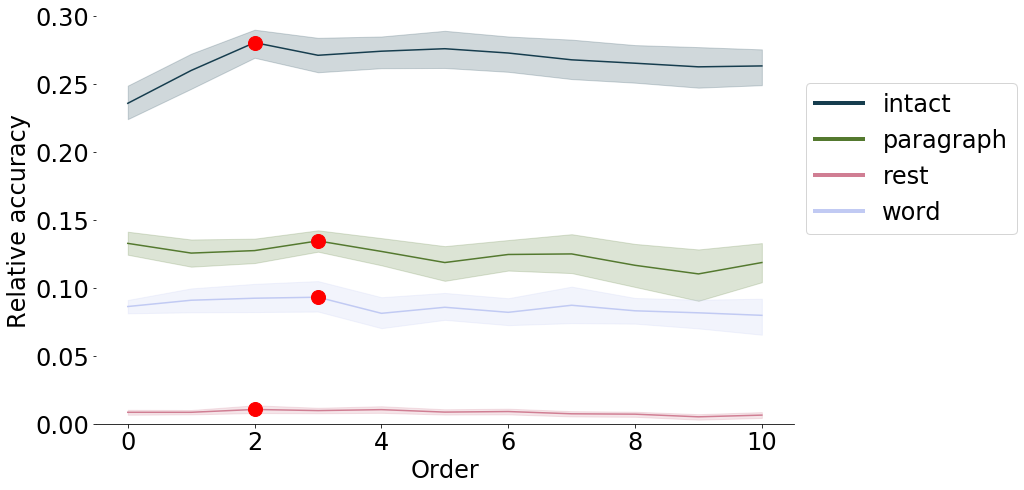

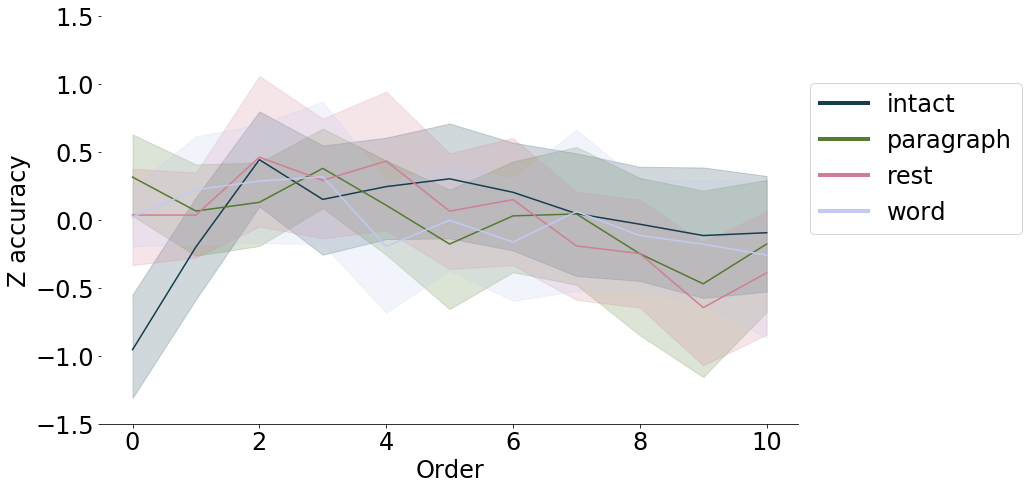

0.26766666666666666
2
isfc eigenvector hat 20


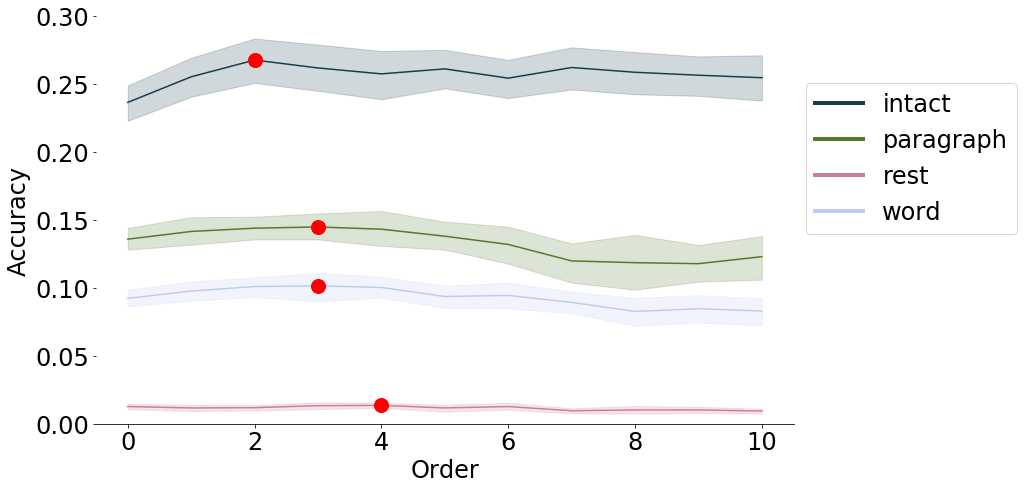

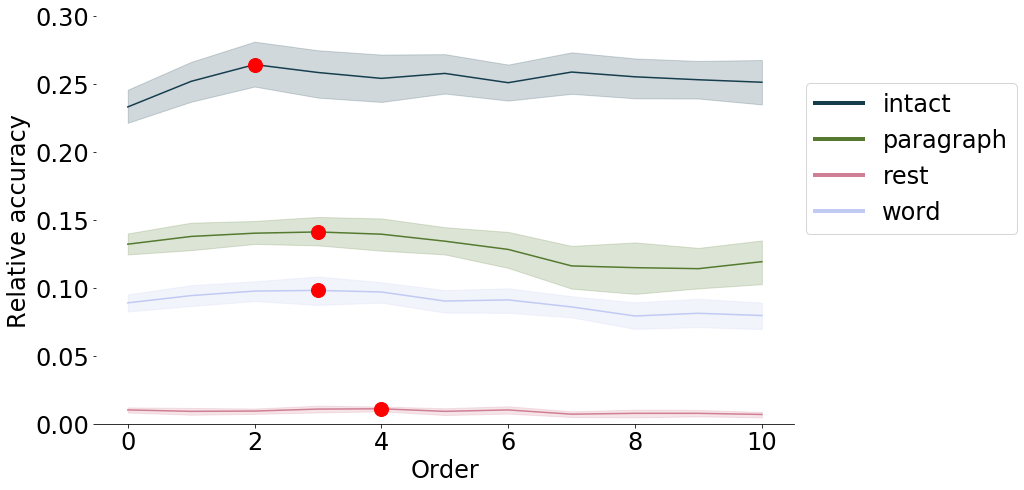

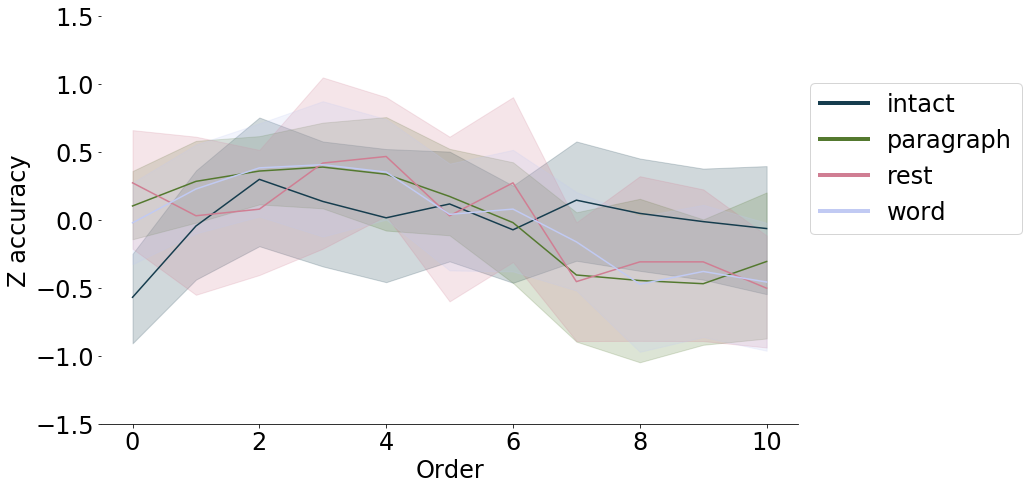

0.27555555555555555
5
isfc eigenvector hat 5


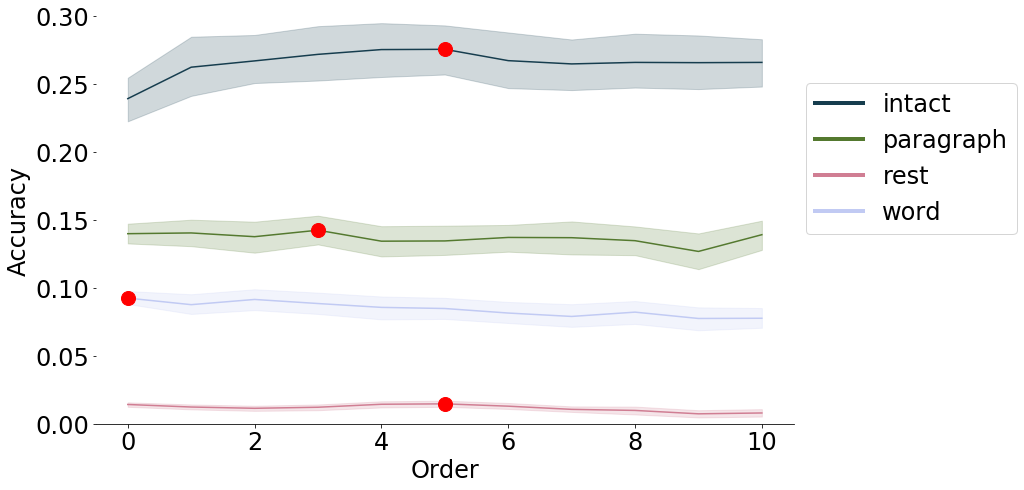

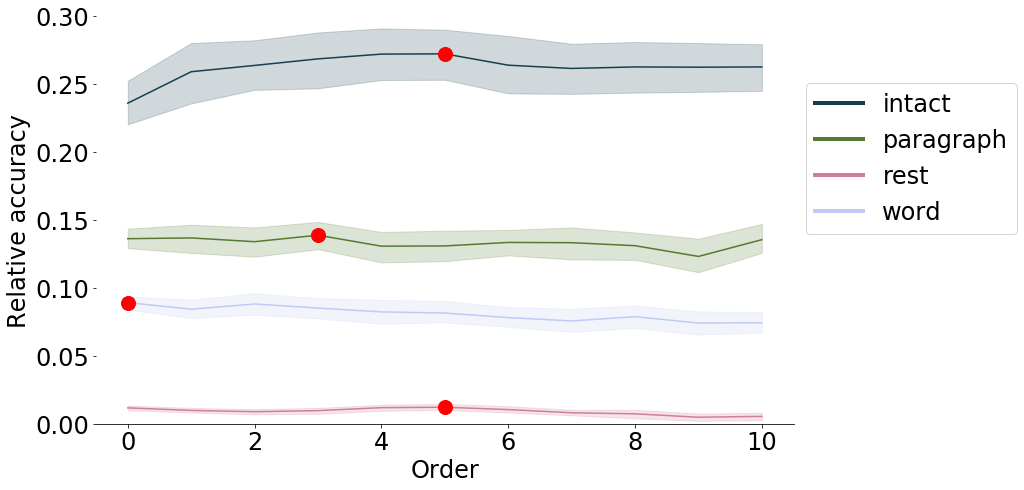

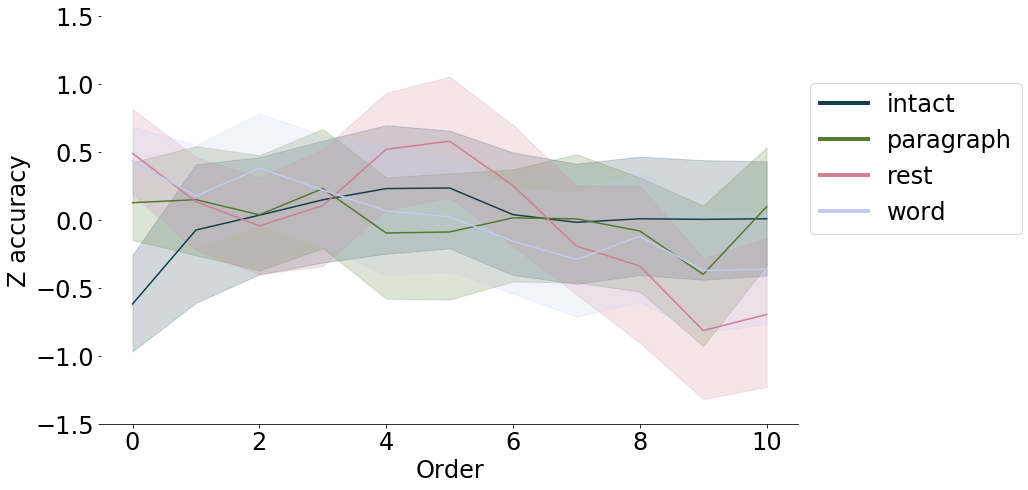

0.26633333333333337
2
isfc eigenvector hat 50


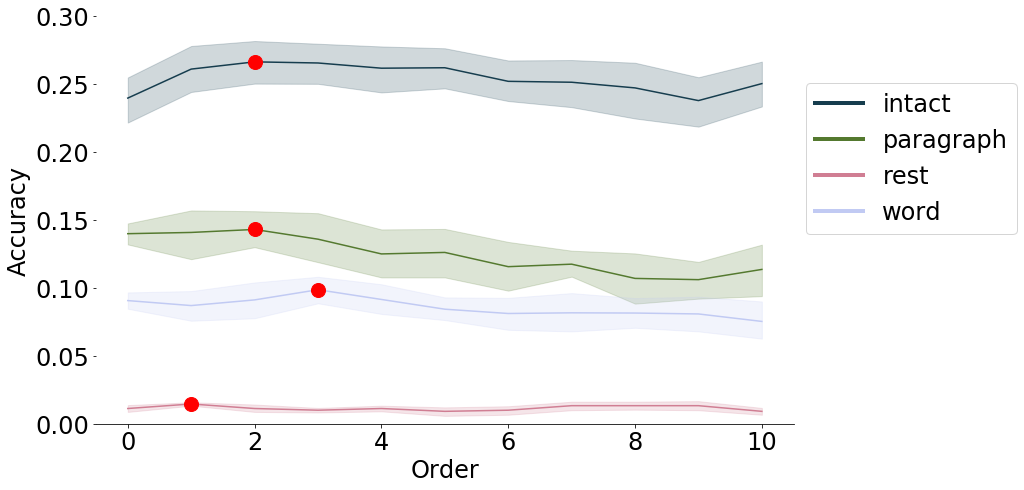

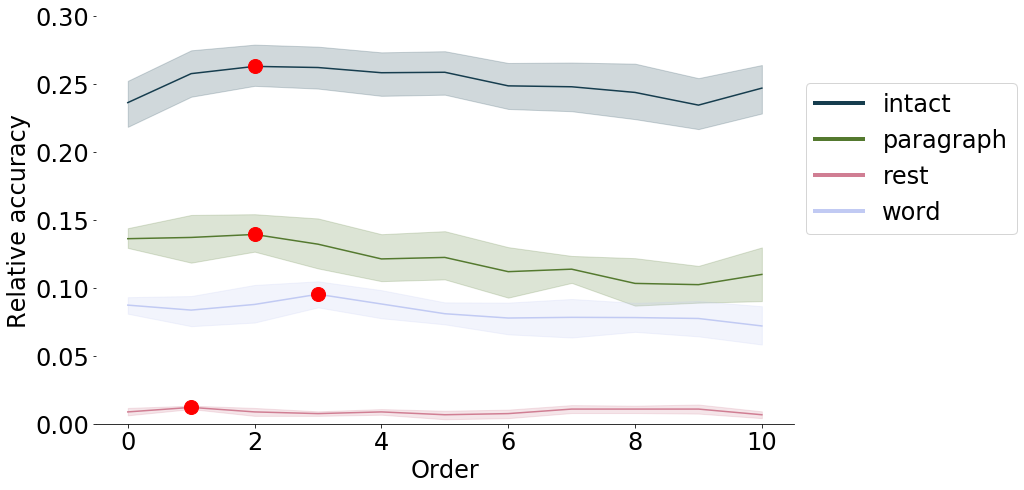

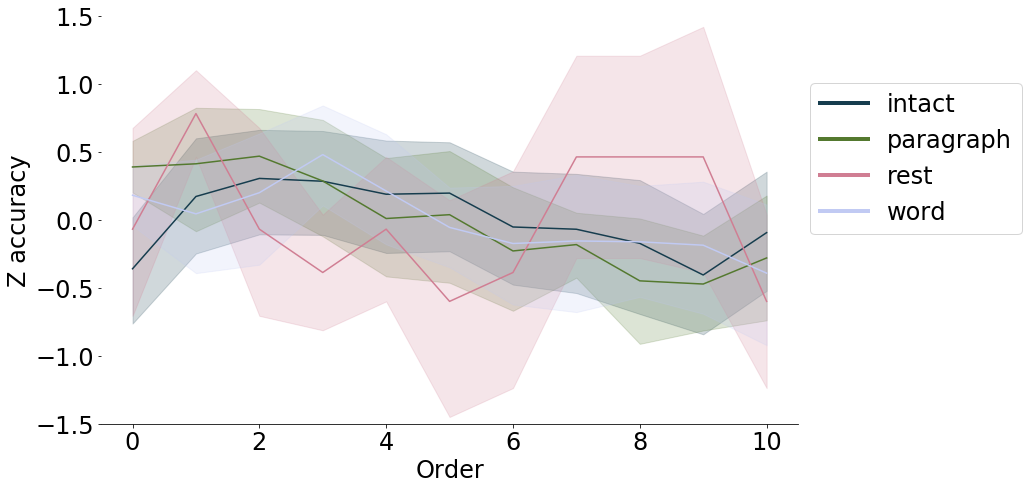

0.252
2
isfc PCA gaussian 10


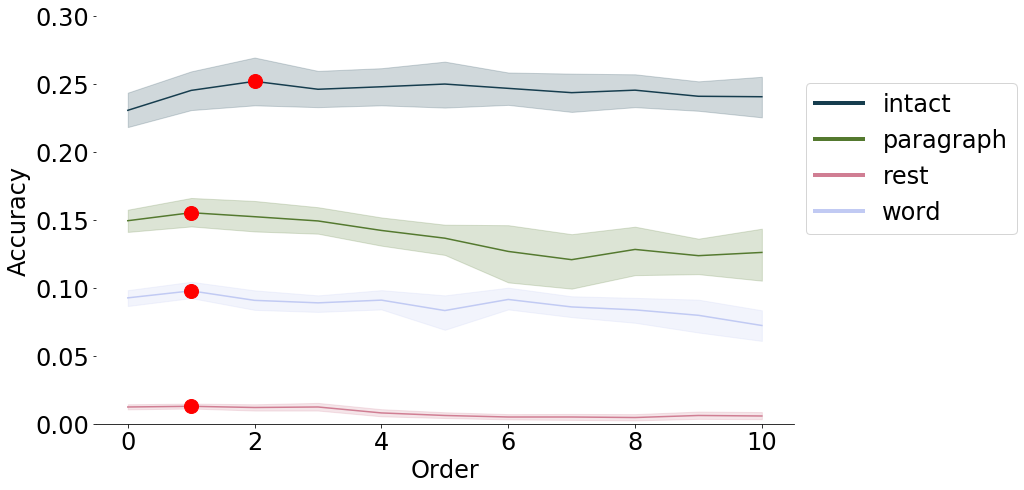

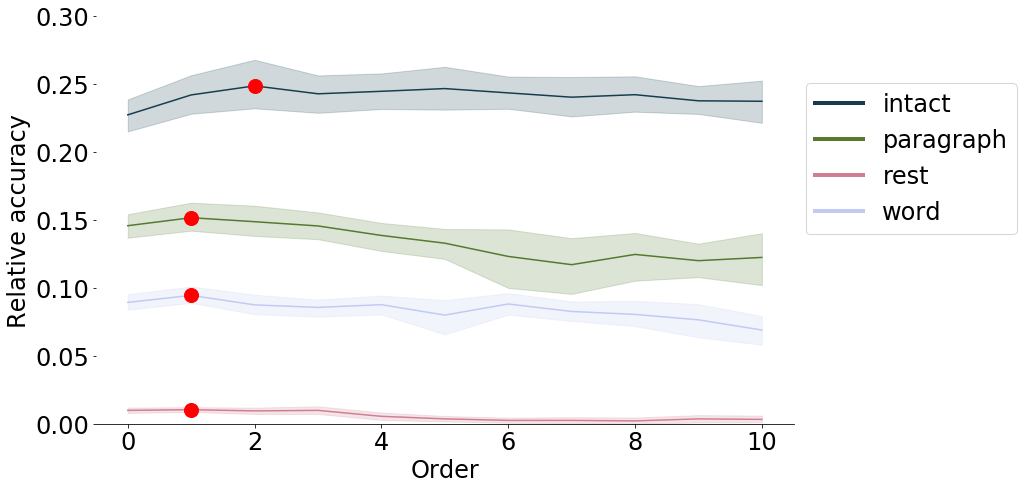

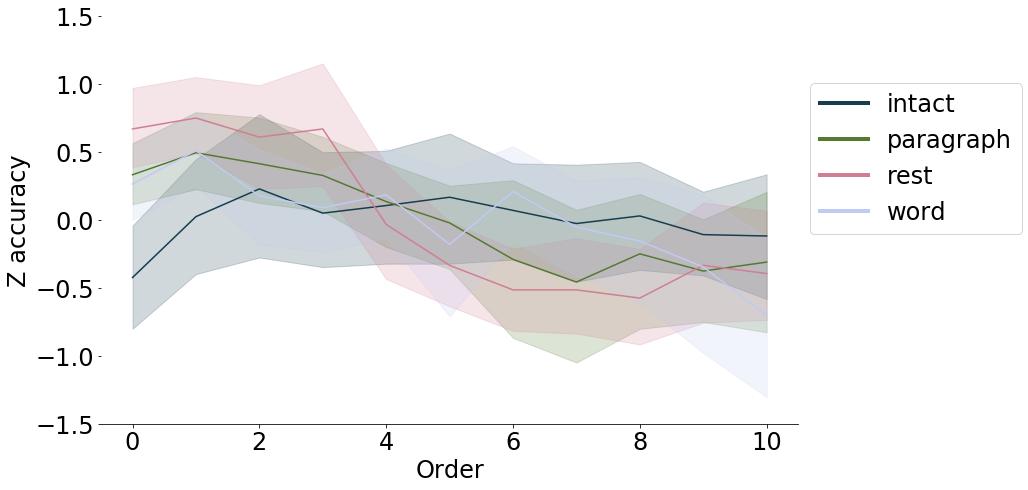

0.27066666666666667
2
isfc PCA gaussian 20


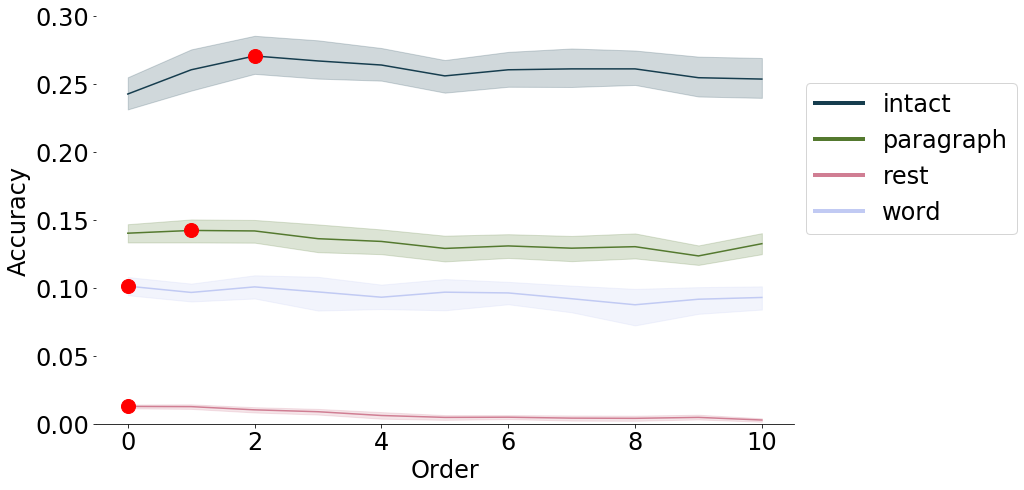

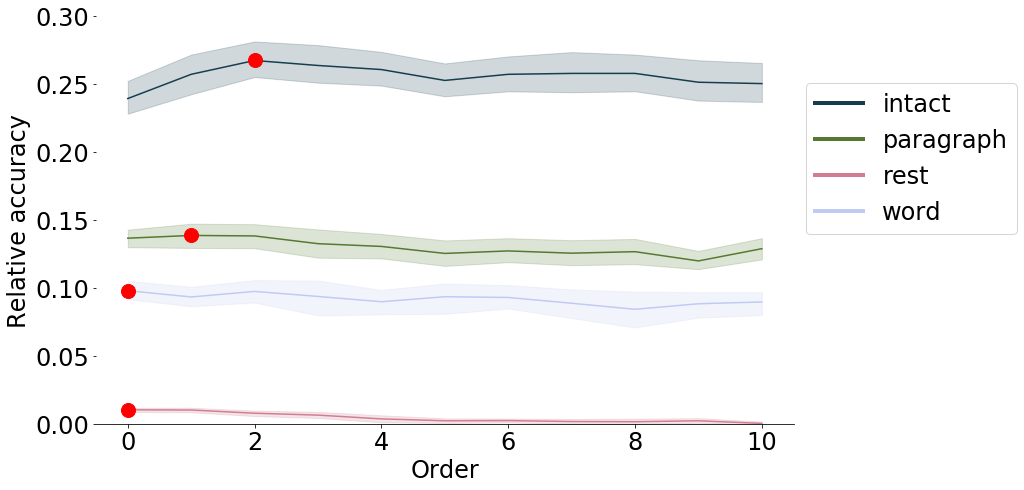

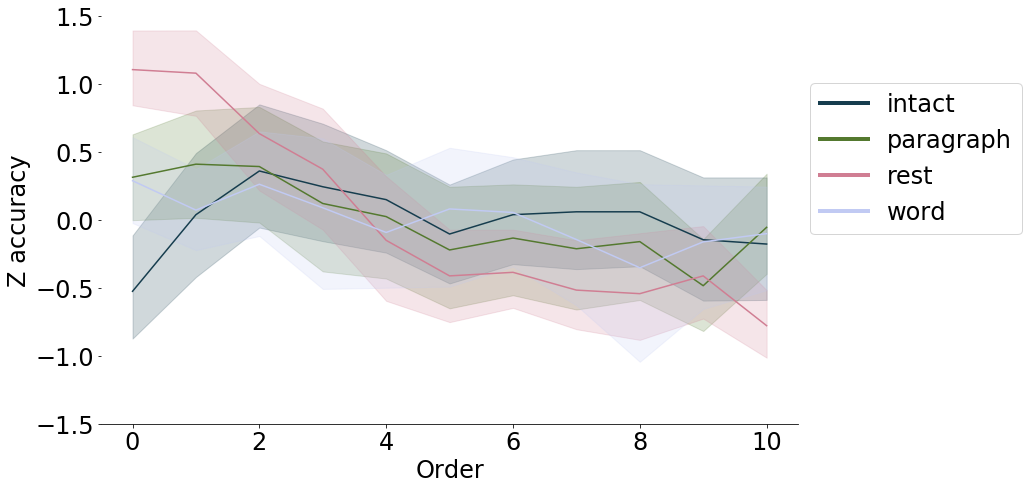

0.261
2
isfc PCA gaussian 5


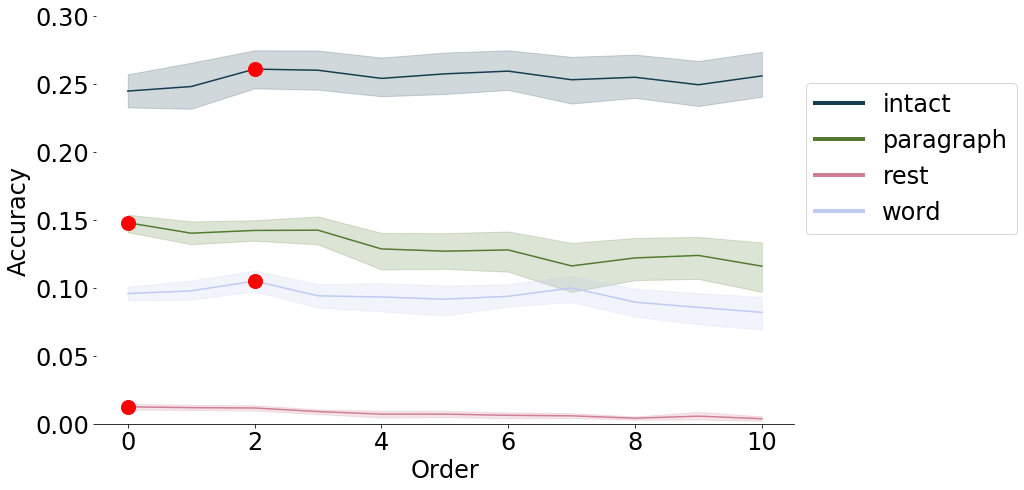

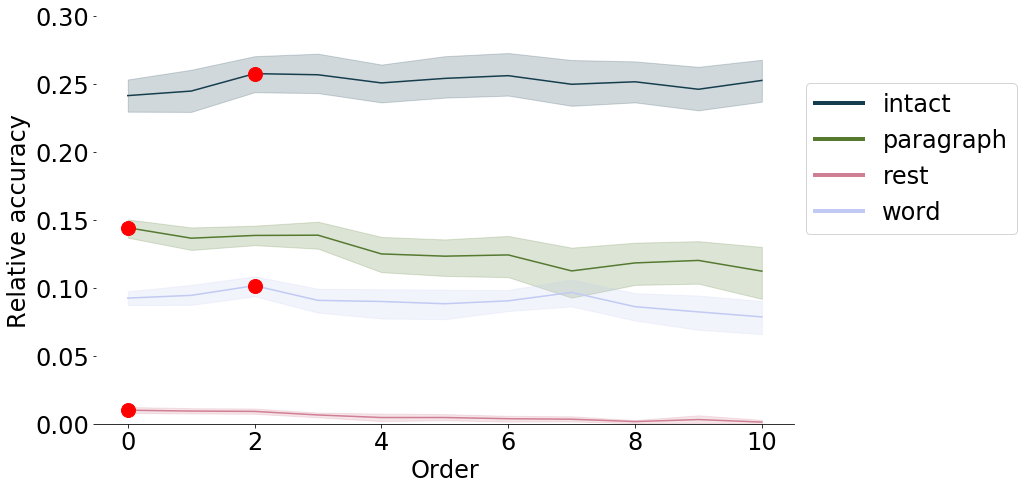

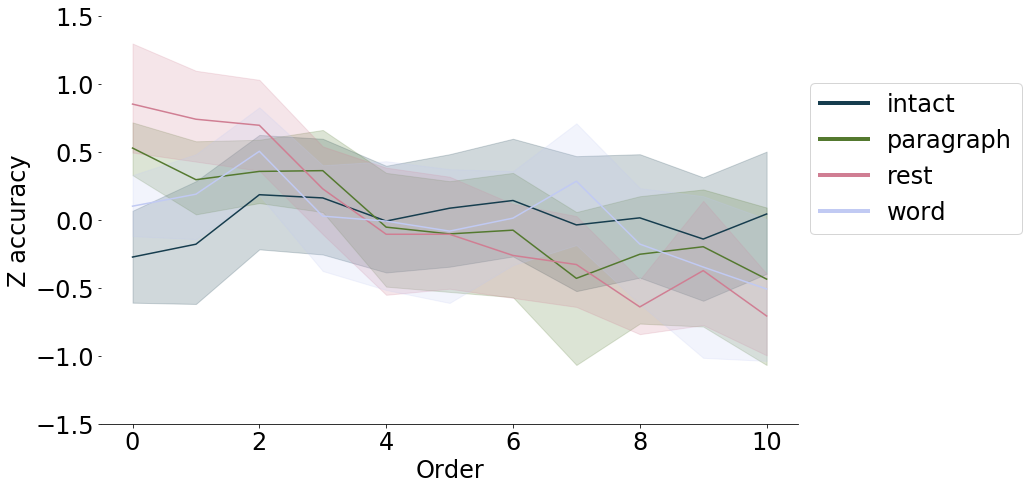

0.25833333333333336
2
isfc PCA gaussian 50


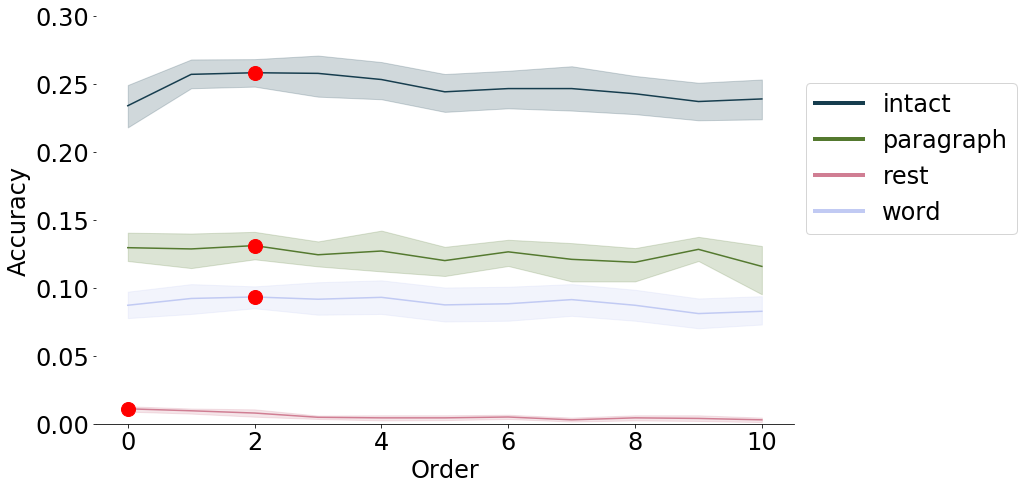

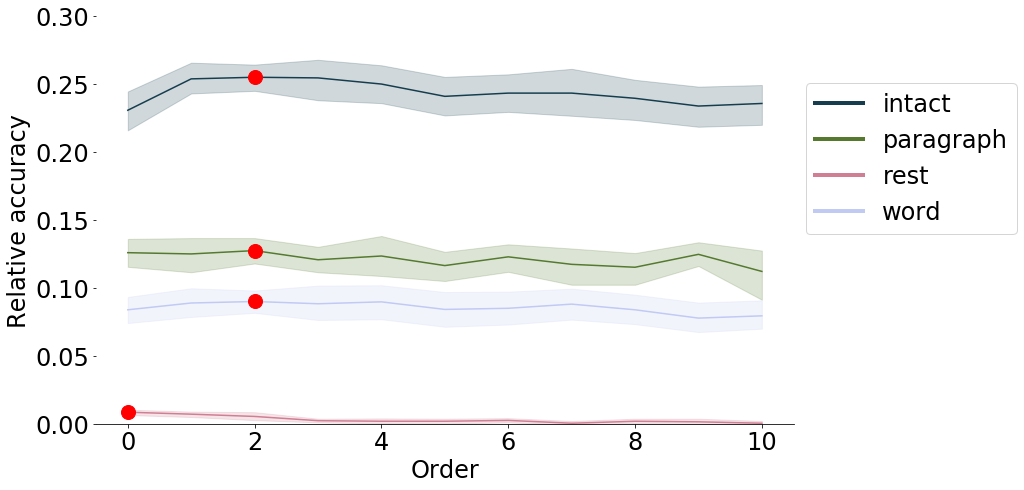

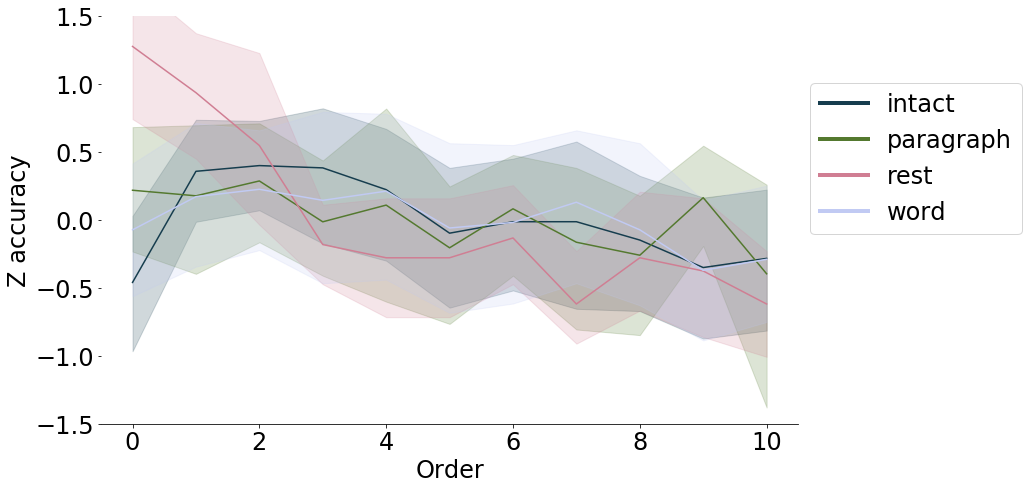

0.25400000000000006
6
isfc PCA laplace 10


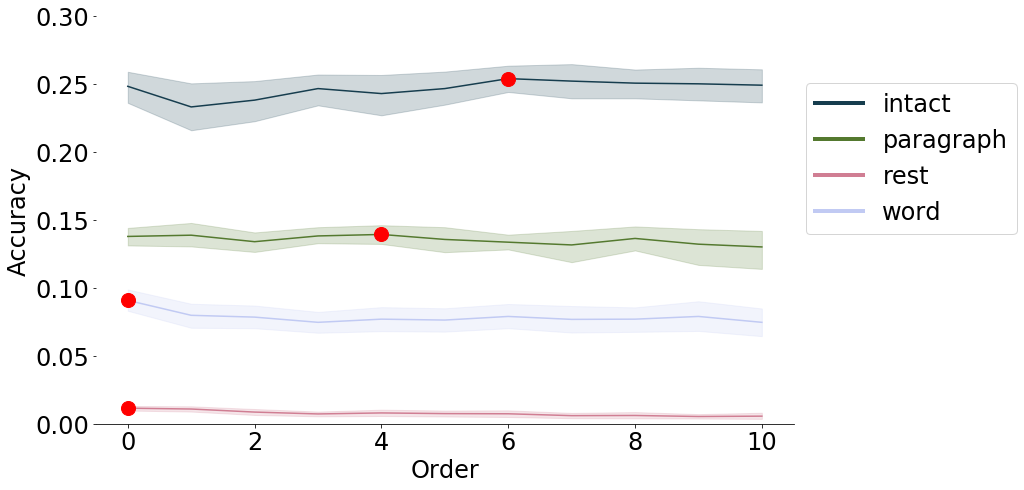

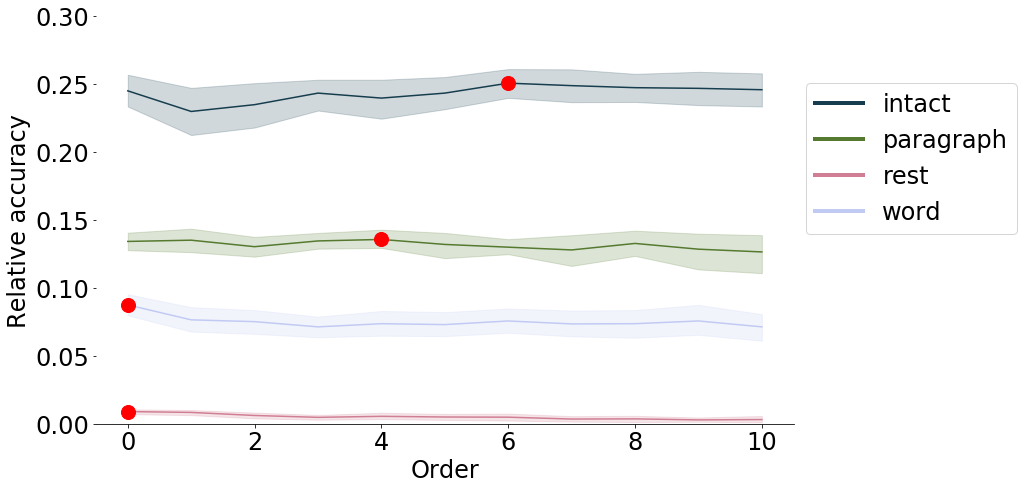

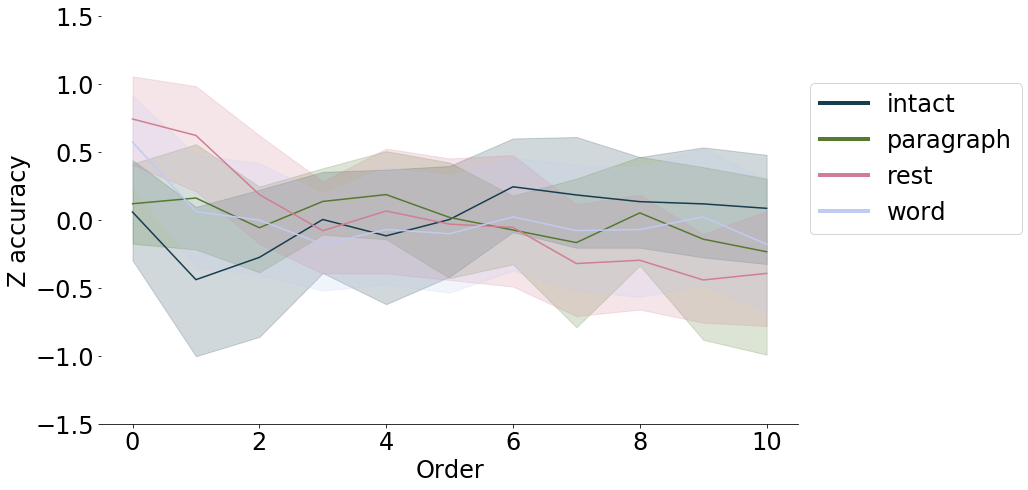

0.24583333333333335
0
isfc PCA laplace 20


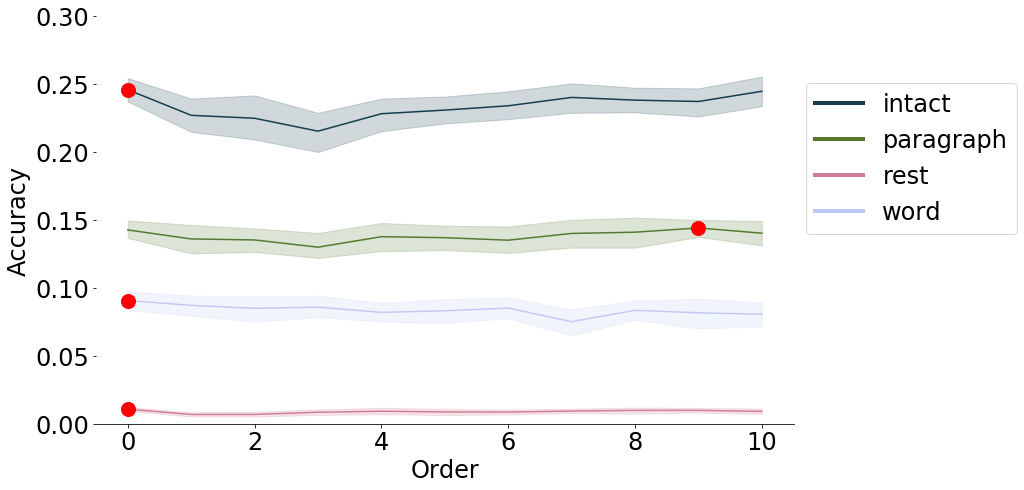

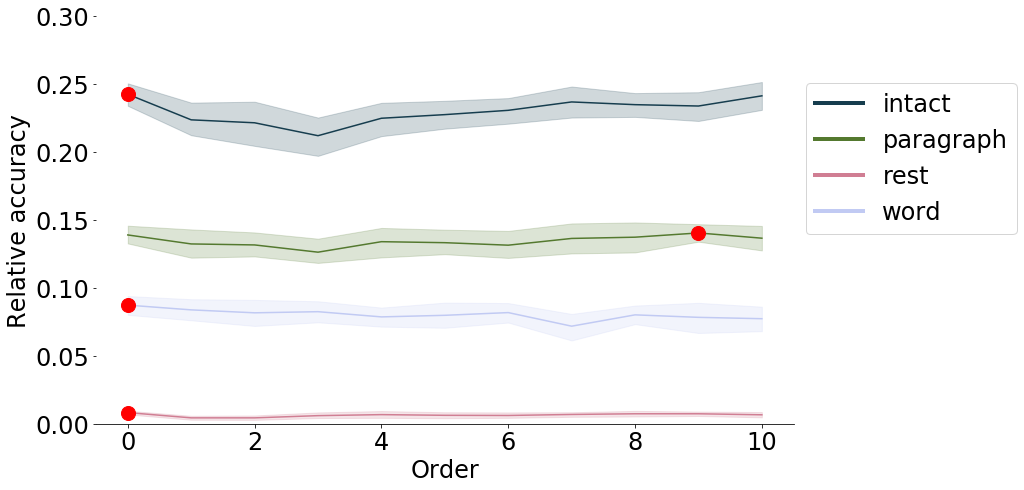

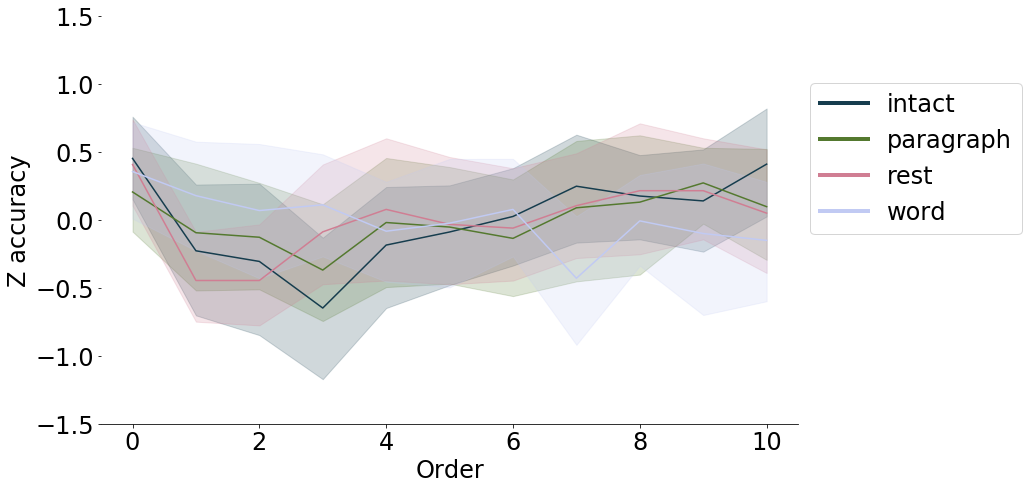

0.25766666666666665
4
isfc PCA laplace 5


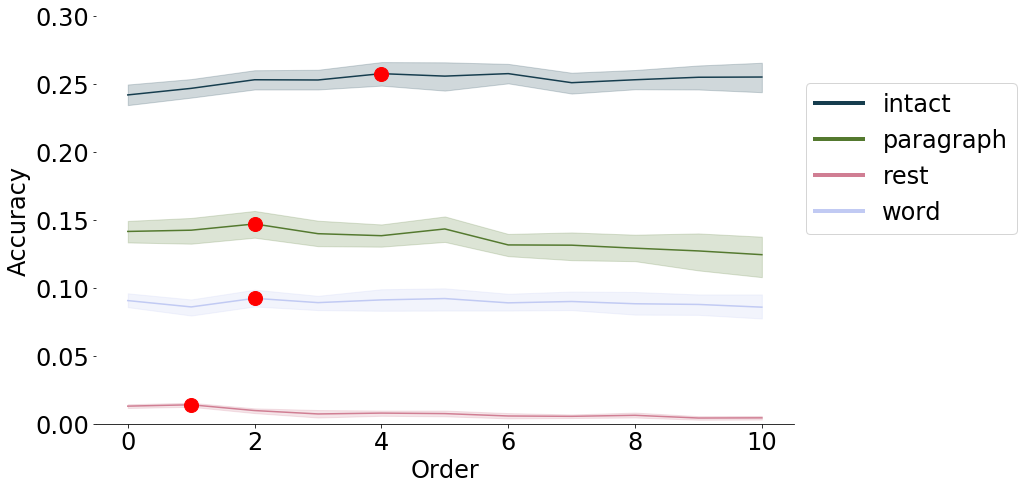

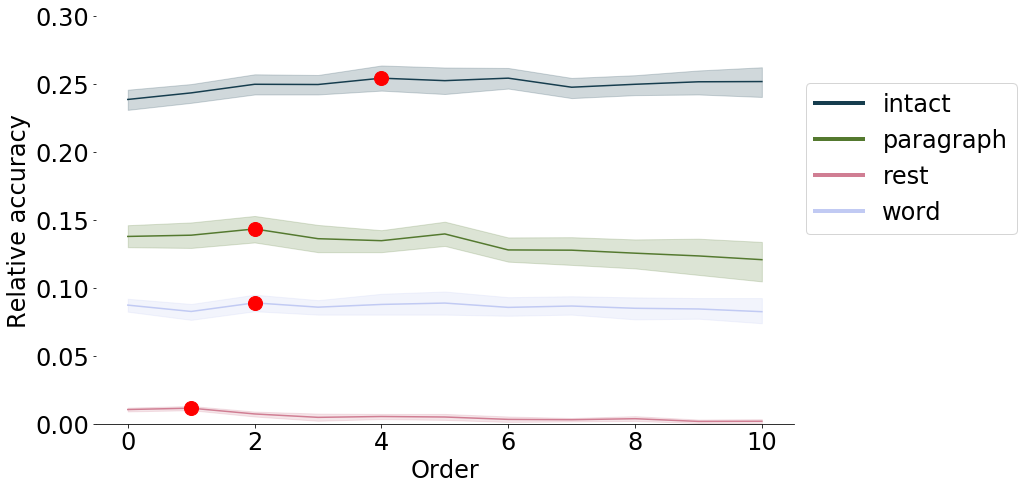

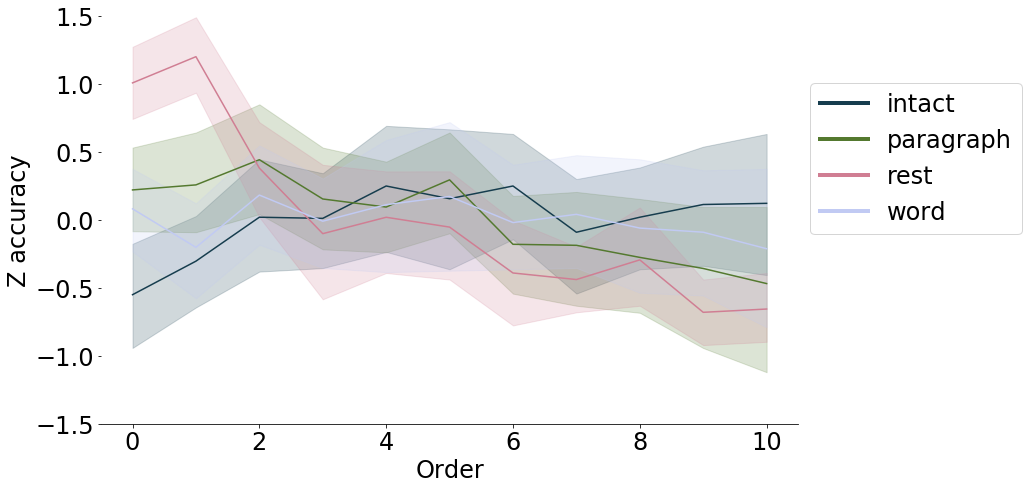

0.2461666666666667
0
isfc PCA laplace 50


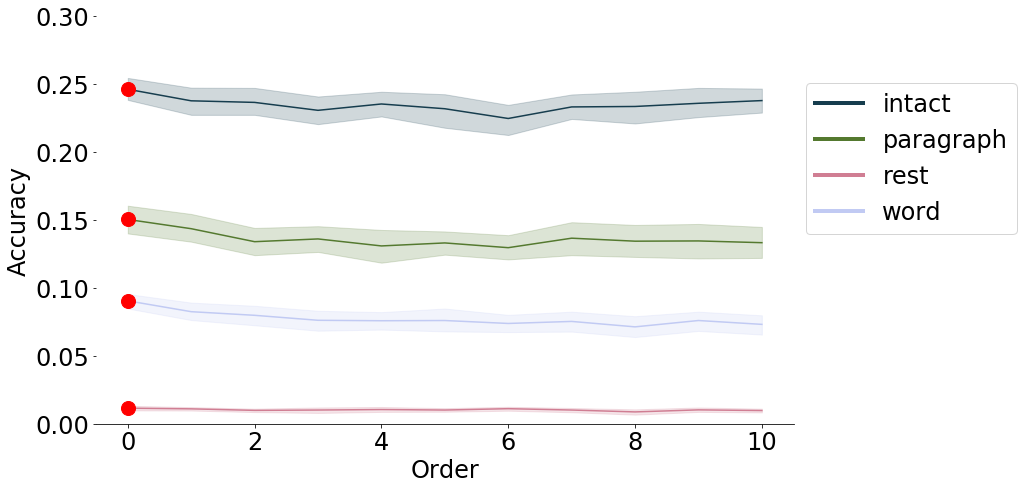

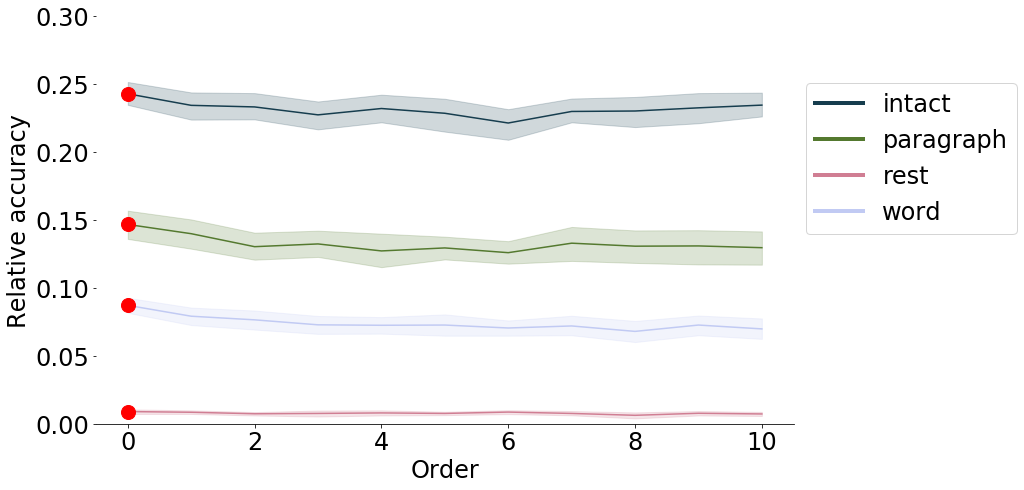

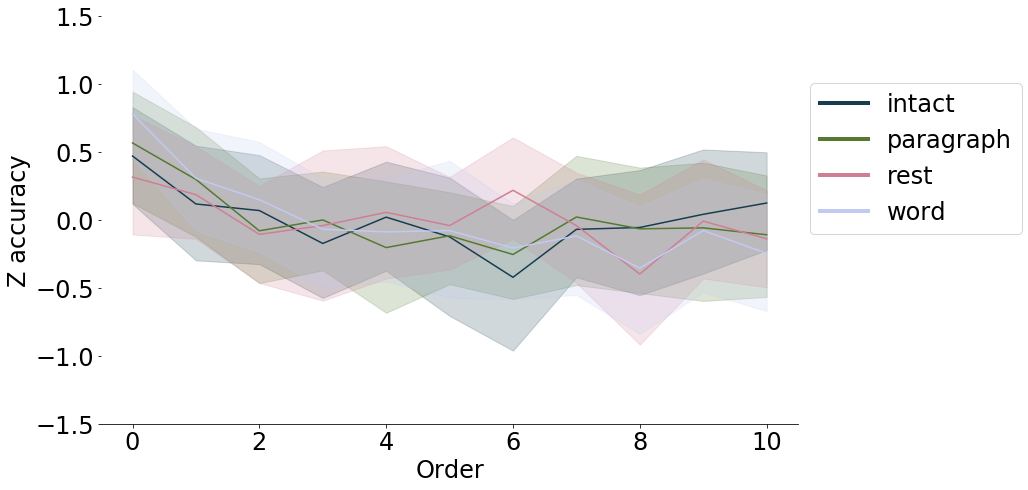

0.25816666666666677
10
isfc PCA hat 10


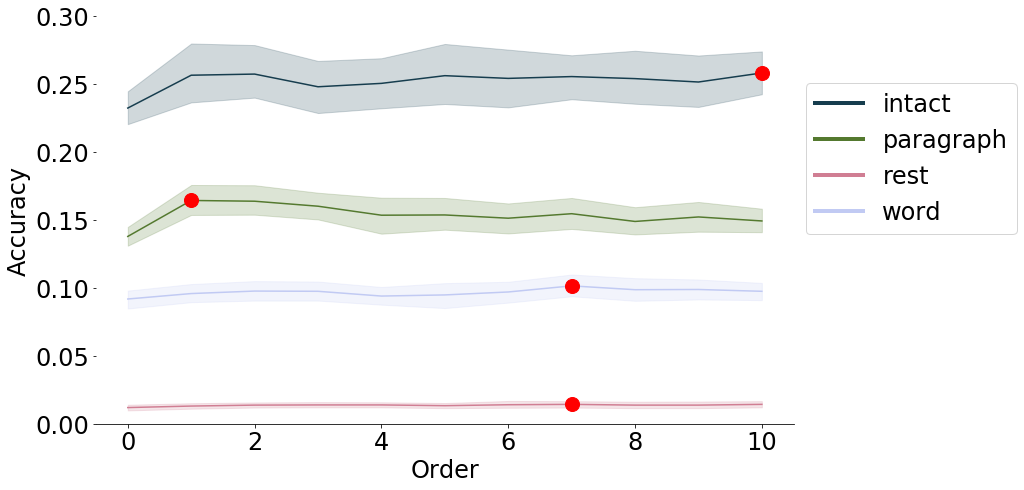

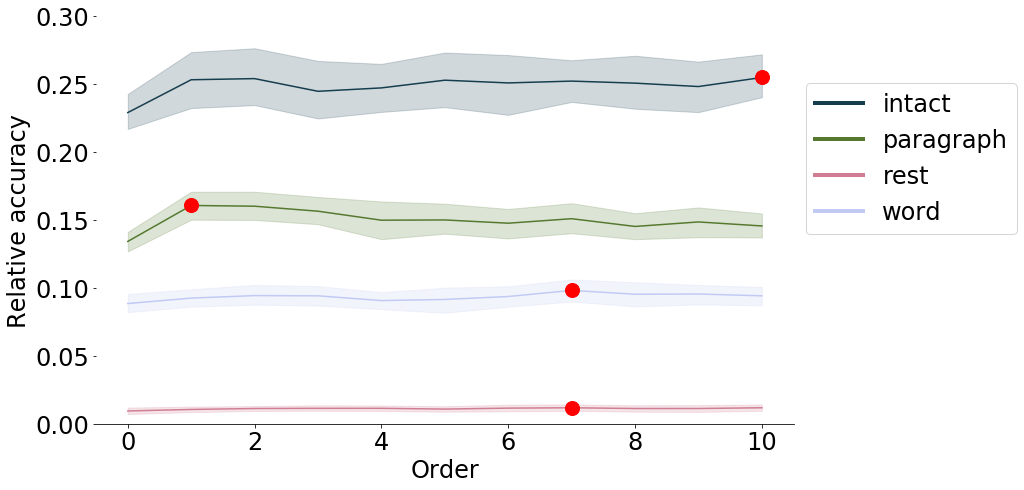

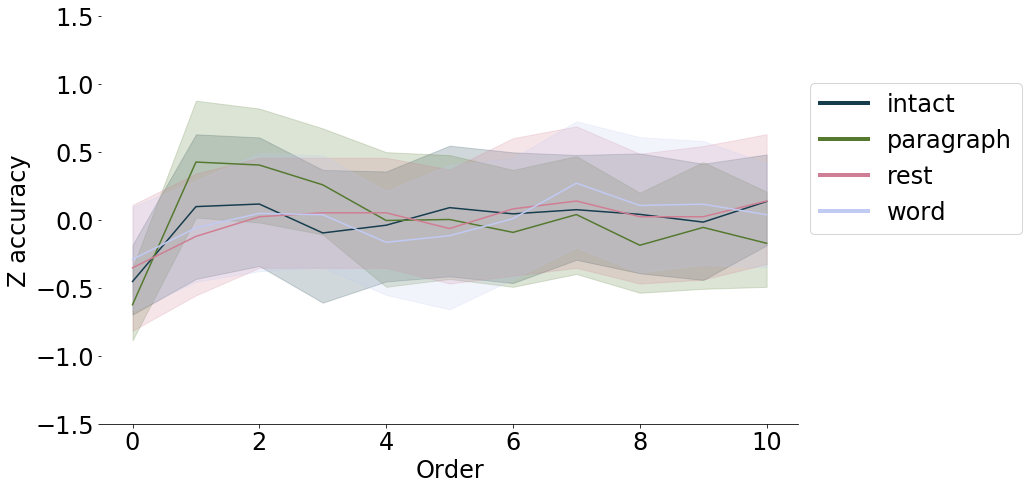

0.28185185185185185
1
isfc PCA hat 20


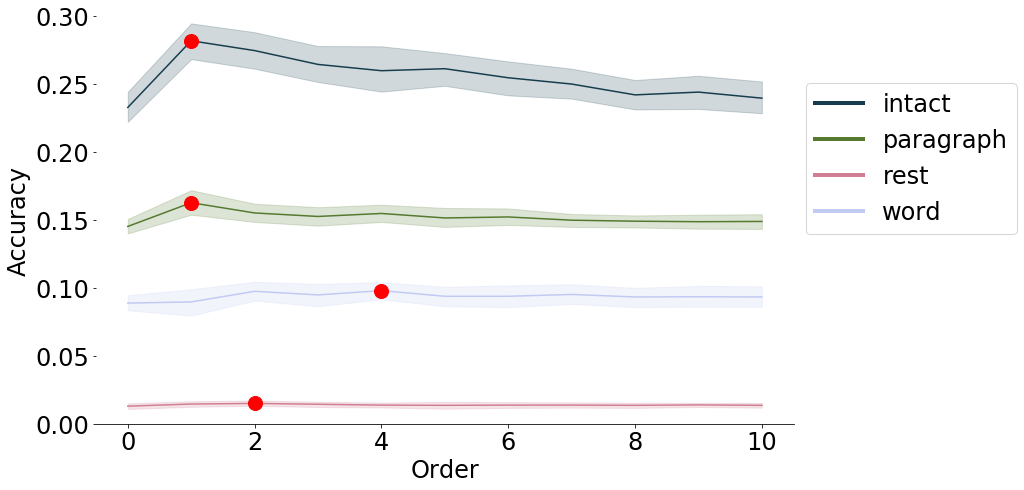

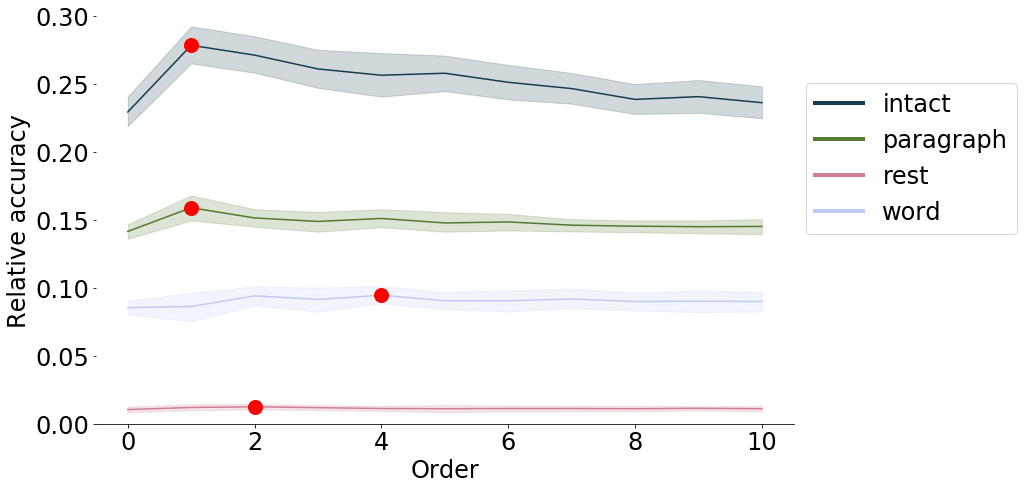

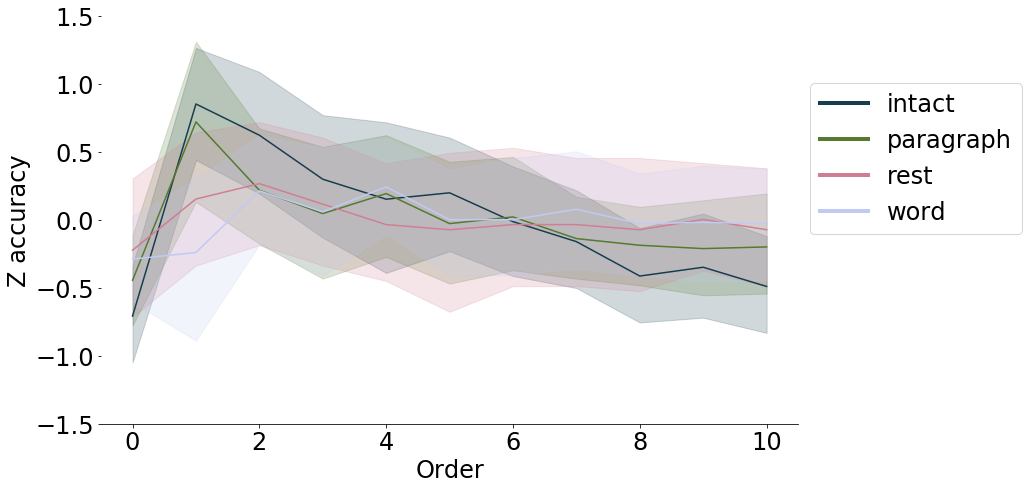

0.26383333333333325
2
isfc PCA hat 5


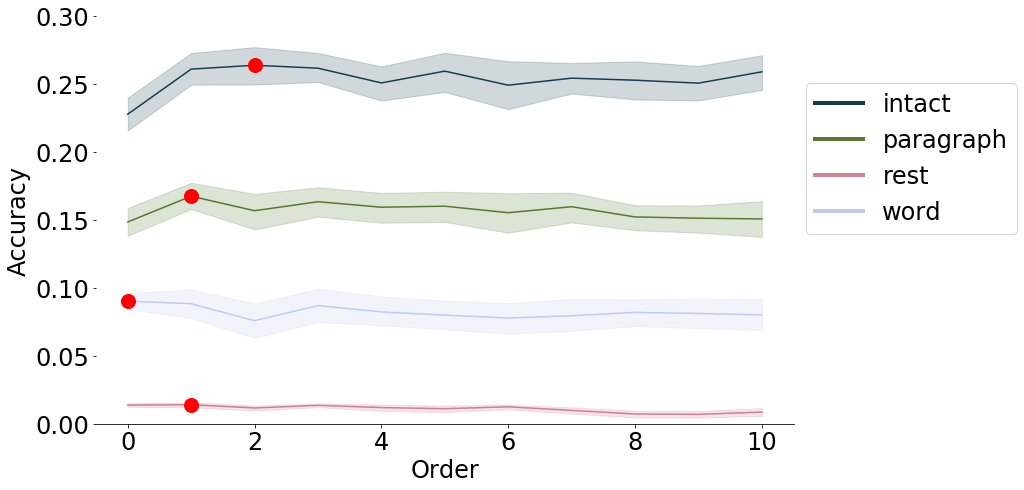

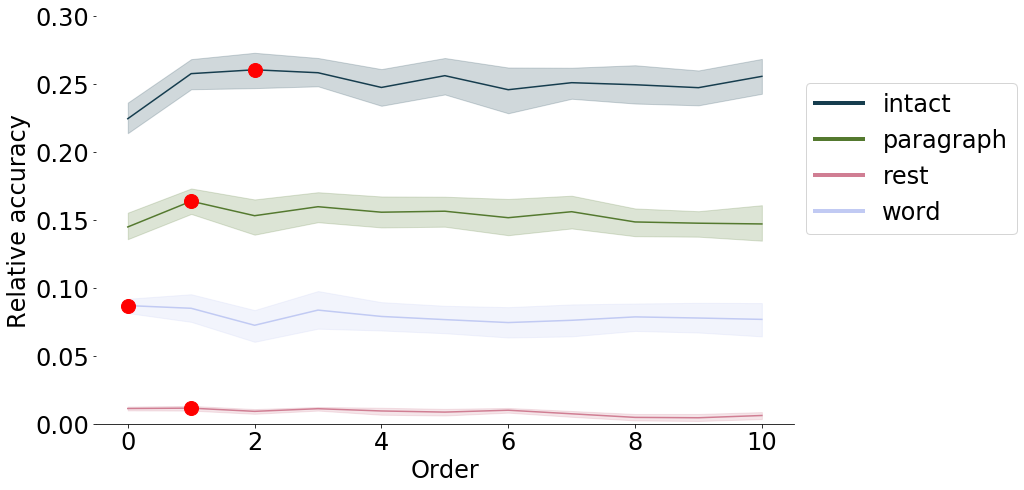

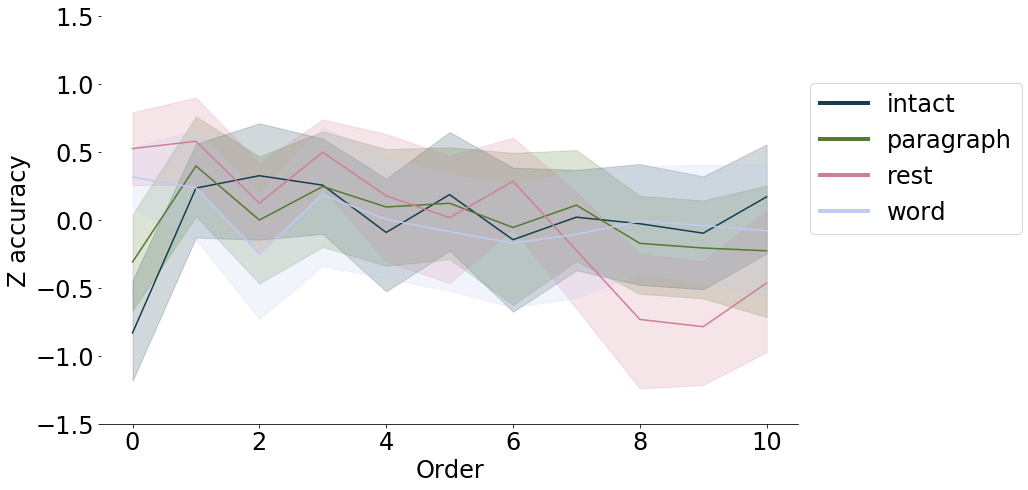

0.2511111111111111
2
isfc PCA hat 50


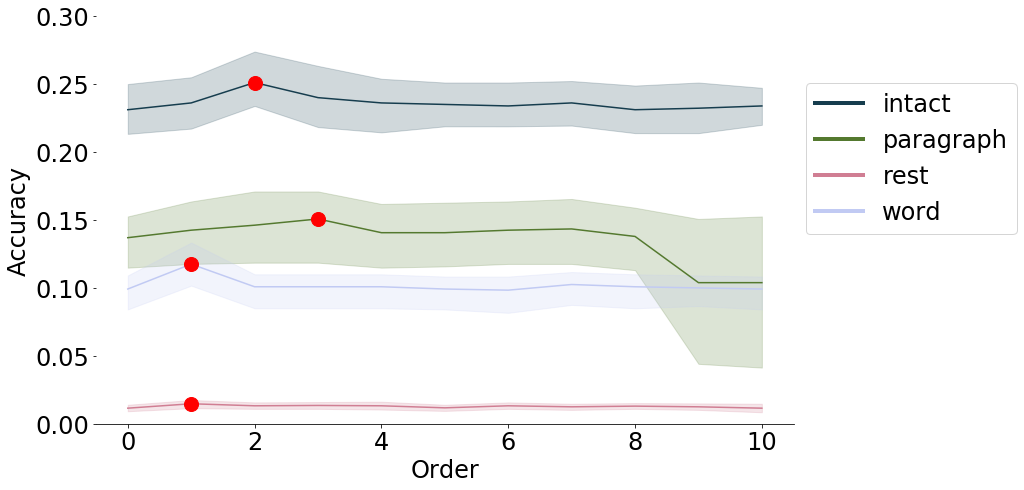

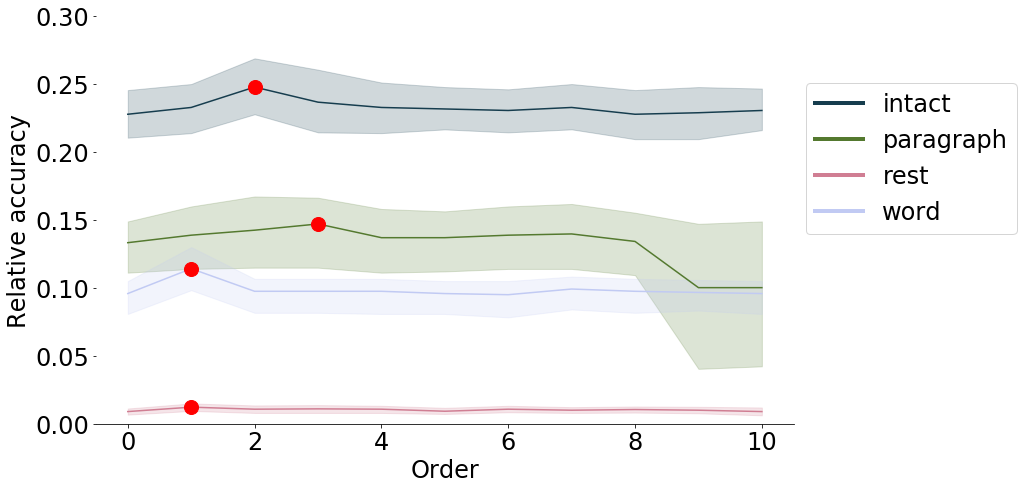

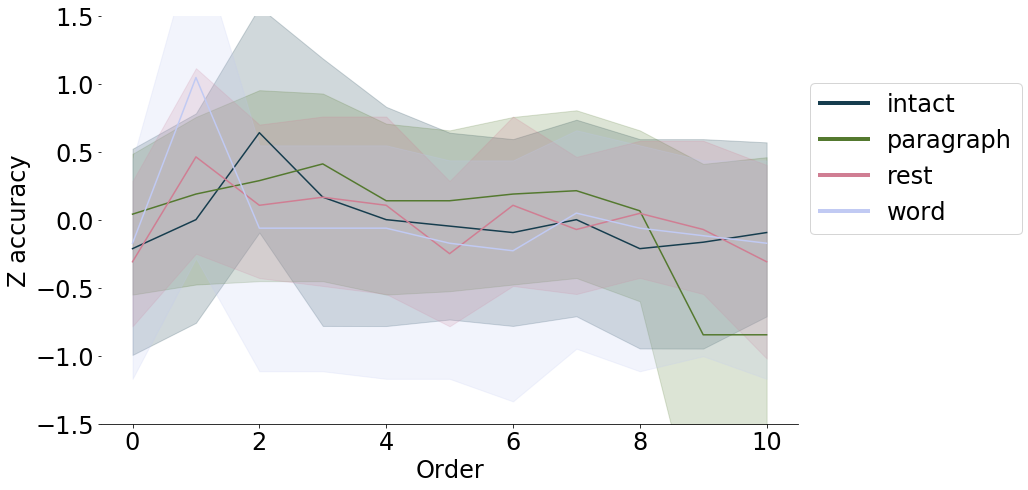

In [22]:

for p in pieman_params:
    param_name = os.path.basename(os.path.splitext(p)[0])

    conds =glob.glob(os.path.join(p, '*.csv'))

    full_data = pd.DataFrame()
    for c in conds:
        
        cond_name = os.path.basename(os.path.splitext(c)[0])
        chance = 1/300      
        if cond_name == 'paragraph':
            chance = 1/272
        elif cond_name == 'rest':
            chance = 1/400
        
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0])
        data['Relative accuracy'] = data['accuracy'] - chance
        data['Normalized accuracy']= data['accuracy'] - np.min(data.groupby('level')['accuracy'].mean())
        data['Normalized accuracy'] = data['Normalized accuracy'] / np.max(data.groupby('level')['Normalized accuracy'].mean())
        data['Z accuracy']= (data['accuracy'] - data['accuracy'].mean())/data['accuracy'].std()
        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

    full_data = full_data.rename(index=str, columns={"level": "Level", "accuracy": "Accuracy", "condition": "Condition"})
    
    p_df = full_data[full_data['Condition']=='intact']
    max_level = p_df.groupby('Level').mean()['Accuracy']
    print(max_level[max_level.argmax()])
    print(max_level.argmax())
    
    p_split = param_name.split('_')

    title = p_split[0] + ' ' + p_split[1] + ' ' + p_split[-2] + ' ' + p_split[-1] 
    print(title)
    
    outfile = None
    #outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
    grouped_lineplot(full_data, 'Level', 'Accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = '', outfile=outfile)
    plt.show()
    plt.close()
    
    #outfile = os.path.join(figdir, param_name + '_relative_line_'+ analysis_name + '.pdf')
    grouped_lineplot(full_data, 'Level', 'Relative accuracy','Condition', plot_marker=True, title = '', ymin=0, ymax=.3, outfile=outfile)
    plt.show()
    plt.close()
    
    #outfile = os.path.join(figdir, param_name + '_z_line_'+ analysis_name + '.pdf')
    grouped_lineplot(full_data, 'Level', 'Z accuracy','Condition', title = '', ymin=-1.5, ymax=1.5, outfile=outfile)
    plt.show()
    plt.close()

In [23]:
#### for individual curves


# for p in params:
#     param_name = os.path.basename(os.path.splitext(p)[0])

#     conds =glob.glob(os.path.join(p, '*.csv'))

#     full_data = pd.DataFrame()
#     for c in conds:
        
#         cond_name = os.path.basename(os.path.splitext(c)[0])
#         chance = 1/300      
#         if cond_name == 'paragraph':
#             chance = 1/272
#         elif cond_name == 'rest':
#             chance = 1/400
        
#         data = pd.read_csv(c)
#         data['condition'] = os.path.basename(os.path.splitext(c)[0])
#         #data['level'] = 20 - data.isnull().sum(axis=1)
#         data['Relative accuracy'] = data['accuracy'] - chance
#         data['Normalized accuracy']= data['accuracy'] - np.min(data.groupby('level')['accuracy'].mean())
#         data['Normalized accuracy'] = data['Normalized accuracy'] / np.max(data.groupby('level')['Normalized accuracy'].mean())
        
#         if full_data.empty:
#             full_data = data
#         else:
#             full_data = full_data.append(data)

#     full_data = full_data.rename(index=str, columns={"level": "Level", "accuracy": "Accuracy", "condition": "Condition"})
    
#     p_df = full_data[full_data['Condition']=='intact']
#     max_level = p_df.groupby('Level').mean()['Accuracy']
#     print(max_level[max_level.argmax()])
#     print(max_level.argmax())
    
#     p_split = param_name.split('_')

#     title = p_split[0] + ' ' + p_split[1] + ' ' + p_split[-2] + ' ' + p_split[-1] 
#     print(title)
    
#     outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
#     grouped_lineplot(full_data, 'Level', 'Accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = '', outfile=outfile)
#     plt.show()
#     plt.close()
    
#     outfile = os.path.join(figdir, param_name + '_relative_line_'+ analysis_name + '.pdf')
#     grouped_lineplot(full_data, 'Level', 'Relative accuracy','Condition', plot_marker=True, title = '', ymin=0, ymax=.3, outfile=outfile)
#     plt.show()
#     plt.close()
    
#     outfile = os.path.join(figdir, param_name + '_normalized_line_'+ analysis_name + '.pdf')
#     grouped_lineplot(full_data, 'Level', 'Normalized accuracy','Condition', title = '', ymin=0, ymax=1.5, outfile=outfile)
#     plt.show()
#     plt.close()